# Bitcoin Volatility Prediction

## Importing Libraries

In [ ]:
# pip install -r requirements.txt

In [4]:
import pandas as pd
import numpy as np
#import missingno as msno
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from pmdarima import auto_arima
from arch import arch_model
import itertools
import os

# Stationary
import statsmodels.graphics.tsaplots as sgt #ACF, PACF
from statsmodels.tsa.stattools import adfuller #ADF
from statsmodels.tsa.stattools import kpss #KPSS
import warnings #경고 무시

# Interpolation
import pmdarima as pm #auto_arima
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm

#time
import time
from sklearn.preprocessing import MinMaxScaler # minmax
from sklearn.inspection import permutation_importance # 순열 중요도

In [5]:
# Print versions
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)
print("scikit-learn version:", sklearn.__version__)  
print("seaborn version:", sns.__version__)
print("pmdarima version:", pm.__version__)
print("statsmodels version:", sm.__version__)

pandas version: 1.5.3
numpy version: 1.24.3
matplotlib version: 3.7.1
scikit-learn version: 1.3.0
seaborn version: 0.12.2
pmdarima version: 2.0.4
statsmodels version: 0.14.0


In [2]:
## 기본 설정 값

# fig
figsize=(15,5)

# 결과창 출력의 최대 행 및 열 수 설정
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 90)

# 경고 무시 설정
# warnings.filterwarnings('ignore')
# KPSS에서 경고가 하나 떴는데 큰 영향을 미치지 않는다고 하여 작성
# 경고 무시 설정은 다른 코드들 작성할 때 주석 처리해 가며 확인 필요

- 리샘플링 함수

In [3]:
def convert_tick_to_ohlcv(data):
    """
    Converts given Binance tick data into 1-hour interval OHLCV (Open, High, Low, Close, Volume) data.
    :param data: DataFrame with Tick data
    :return: DataFrame with the Open, High, Low, Close, Volume values
    """

    data['time'] = pd.to_datetime(data['time'], unit='ms')
    ohlcv = data.resample('1H', on='time').agg({
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum',
        'price': 'mean',
        'quote_qty': 'std',
        'is_buyer_maker': 'sum'
        
})

    ohlcv.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    return ohlcv

def calculate_volatility(data, window=20):
    """
    Calculate the rolling volatility using the standard deviation of returns.
    :param data: DataFrame with OHLCV data
    :param window: The number of periods to use for calculating the standard deviation
    :return: DataFrame with the volatility values
    """

    # Calculate daily returns
    data['returns'] = data['Close'].pct_change()

    # Calculate the rolling standard deviation of returns
    data['volatility'] = data['returns'].rolling(window=window).std()

    return data

### Loading Data

In [4]:
df = pd.read_csv('BIT_2023_1차.csv')
df.set_index('time', inplace=True)
df.index=pd.to_datetime(df.index)
dfc=df.copy()

In [5]:
df.isnull().sum()

Open               24
High               24
Low                24
Close              24
Volume              0
returns            12
volatility        186
price              24
quote_qty          24
is_buyer_maker      0
quote_qty_cal      24
dtype: int64

### Sloving Caution

In [6]:
# 경고 해결용(returns ARIMA) - 인덱스에 주파수 정보 추가

# 기존 데이터프레임의 인덱스를 활용하여 새로운 인덱스 생성
new_date_rng = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# 새로운 인덱스를 기존 데이터프레임의 인덱스로 설정
df = df.reindex(new_date_rng)

## 1. Preprocessing

#### VIsualizing - functions

In [7]:
# 시간단위 출력 함수

def Visualizing_returns(dfc, df, start_date, end_date, figsize=(15,5)):
    
    dfc_filtered = dfc.loc[start_date:end_date]
    df_filtered = df.loc[start_date:end_date]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    
    ax[0].plot(dfc_filtered.index, dfc_filtered)
    ax[0].set_ylabel('returns')
    ax[0].set_title(f'{start_date}-{end_date}')
    ax[0].set_xticks([])

    ax[1].plot(df_filtered.index, df_filtered)
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('returns')
    ax[1].set_title(f'{start_date}-{end_date}')
    
    ax[1].xaxis.set_major_locator(mdates.HourLocator())
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    ax[1].tick_params(axis='x', rotation=45)
    
    plt.show()

In [8]:
# 일단위 출력 함수

def Visualizing_returns_d(dfc, df, start_date, end_date, figsize=(15,5)):
    
    df_filtered = df.loc[start_date:end_date]
    dfc_filtered = dfc.loc[start_date:end_date]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    
    ax[0].plot(df_filtered.index, dfc_filtered)
    ax[0].set_ylabel('returns')
    ax[0].set_title(f'{start_date}-{end_date}')
    ax[0].set_xticks([])

    ax[1].plot(df_filtered.index, df_filtered)
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('returns')
    ax[1].set_title(f'{start_date}-{end_date}')
    
    ax[1].xaxis.set_major_locator(mdates.DayLocator())
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[1].tick_params(axis='x', rotation=45)
    
    plt.show()

### 1-1. Checking Missing Value

#### - price(Open, High, Low, Close, price), quote_qty, quote_qty_cal

In [9]:
display(df[df['price'].isnull()].index)

DatetimeIndex(['2023-01-23 21:00:00', '2023-01-23 22:00:00',
               '2023-01-23 23:00:00', '2023-01-24 21:00:00',
               '2023-01-24 22:00:00', '2023-01-24 23:00:00',
               '2023-01-25 16:00:00', '2023-01-25 17:00:00',
               '2023-01-25 18:00:00', '2023-01-25 19:00:00',
               '2023-01-25 20:00:00', '2023-01-25 21:00:00',
               '2023-01-25 22:00:00', '2023-01-25 23:00:00',
               '2023-01-26 22:00:00', '2023-01-26 23:00:00',
               '2023-03-14 23:00:00', '2023-03-15 22:00:00',
               '2023-03-15 23:00:00', '2023-11-21 03:00:00',
               '2023-11-21 04:00:00', '2023-11-21 05:00:00',
               '2023-11-21 06:00:00', '2023-11-21 07:00:00'],
              dtype='datetime64[ns]', freq=None)

In [10]:
# spline 보간
def spline_interpolate_column(df, column_name, order=3):
    df[column_name] = df[column_name].interpolate(method='spline', order=order)

In [11]:
columns_to_interpolate = ['Open', 'High', 'Low', 'Close','price']

for column in columns_to_interpolate:
    spline_interpolate_column(df, column, order=3)

In [12]:
columns_to_interpolate_volume = ['quote_qty','quote_qty_cal']

for column in columns_to_interpolate_volume:
    spline_interpolate_column(df, column, order=3)

/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


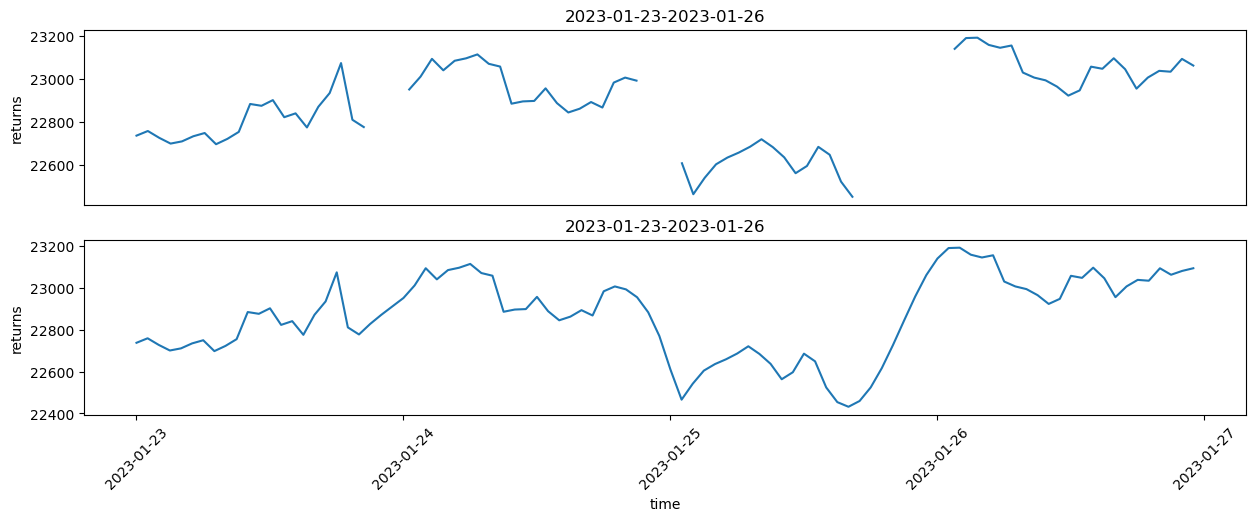

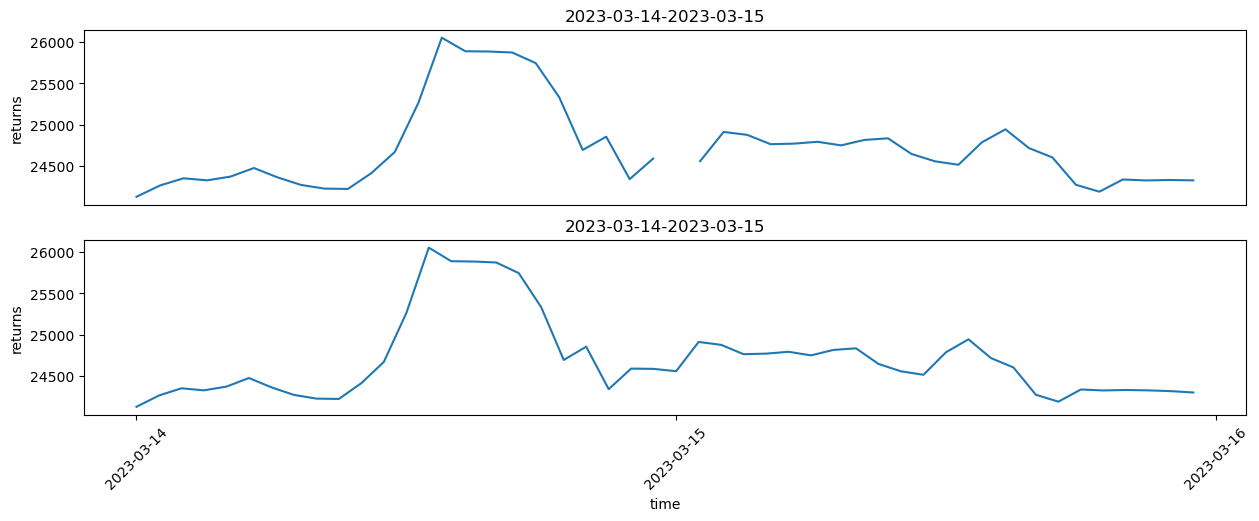

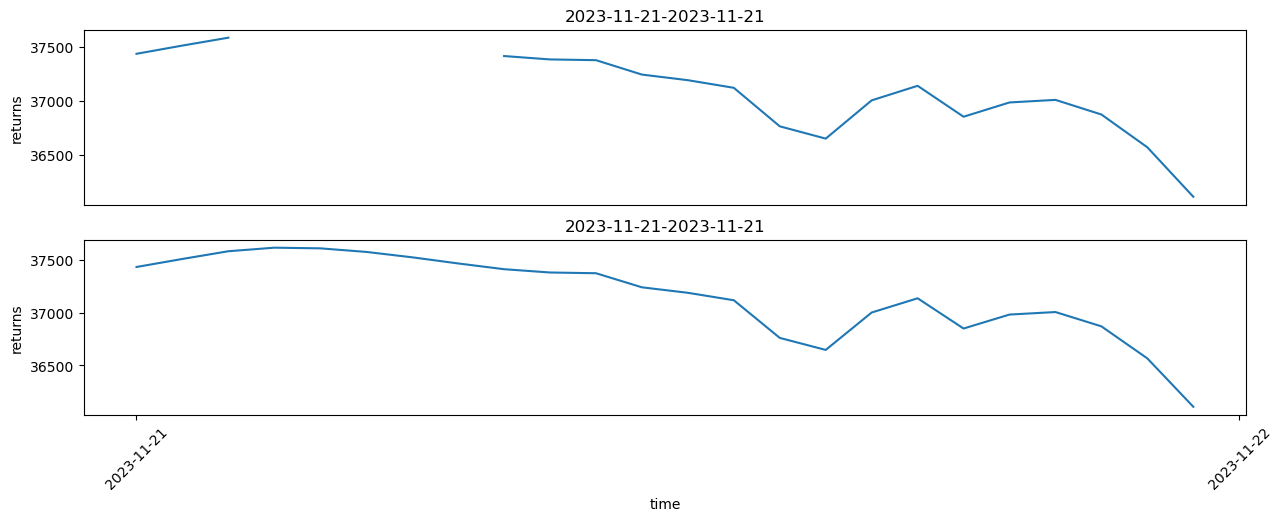

In [13]:
Visualizing_returns_d(dfc['price'], df['price'],'2023-01-23', '2023-01-26')
Visualizing_returns_d(dfc['price'], df['price'],'2023-03-14', '2023-03-15')
Visualizing_returns_d(dfc['price'], df['price'],'2023-11-21', '2023-11-21')

In [14]:
df.isna().sum()

Open                0
High                0
Low                 0
Close               0
Volume              0
returns            12
volatility        186
price               0
quote_qty           0
is_buyer_maker      0
quote_qty_cal       0
dtype: int64

#### - returns

In [15]:
df[df['returns'].isnull()].index # 매달 1일 1시간

DatetimeIndex(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', freq=None)

In [16]:
# auto_arima 사용을 위한 drop
df_returns=df['returns'].dropna()
# auto_arima
autoarima_model = pm.auto_arima(df_returns, suppress_warnings=True)
print(autoarima_model)

 ARIMA(1,0,2)(0,0,0)[0] intercept


In [17]:
# 결측치 보간을 위한 ARIMA 모델 훈련 함수

def interpolate_arima(data, order):
    
    # 결측치 보간 전 ARIMA 모델 훈련
    model = sm.tsa.ARIMA(data.dropna(), order=order)  # p, d, q는 ARIMA 모델의 차수
    results = model.fit()


    # 보간할 결측치 선택
    missing_indices = data[data.isnull()].index

    # 결측치 보간
    for idx in missing_indices:
        # ARIMA 모델을 사용하여 결측치 예측
        predicted_value = results.get_forecast(steps=1).predicted_mean.iloc[0]  # 예측 결과의 첫 번째 값을 사용

        # 결측치 보간
        data[idx] = predicted_value


# 시계열 데이터에 대한 결측치 보간
interpolate_arima(df['returns'], (1, 0, 2))

/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

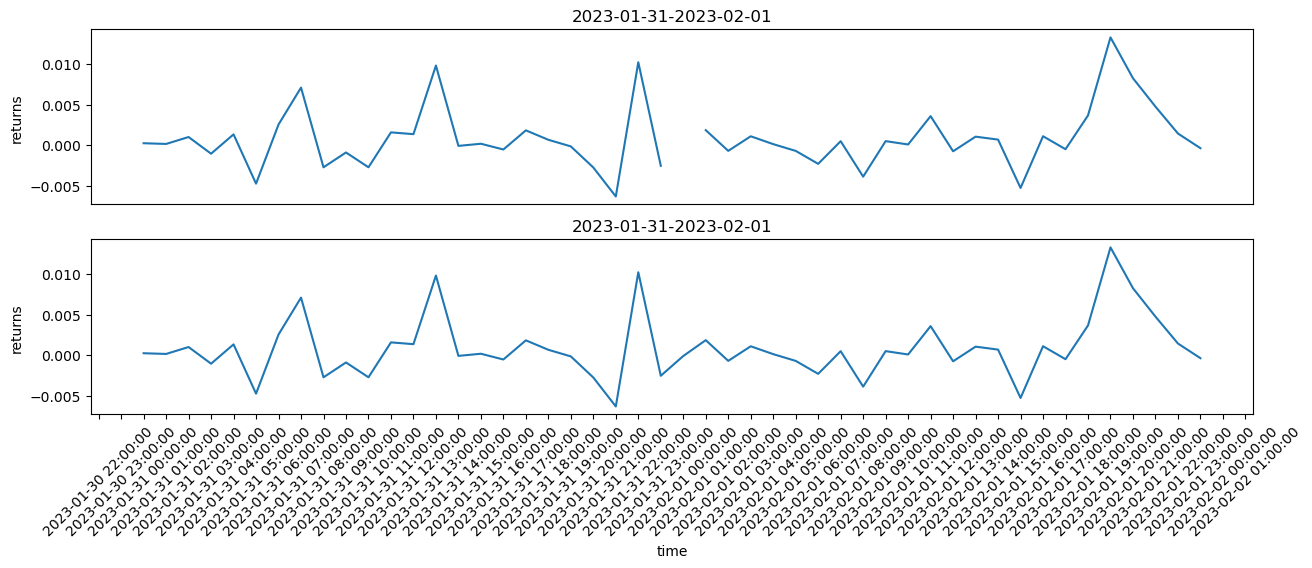

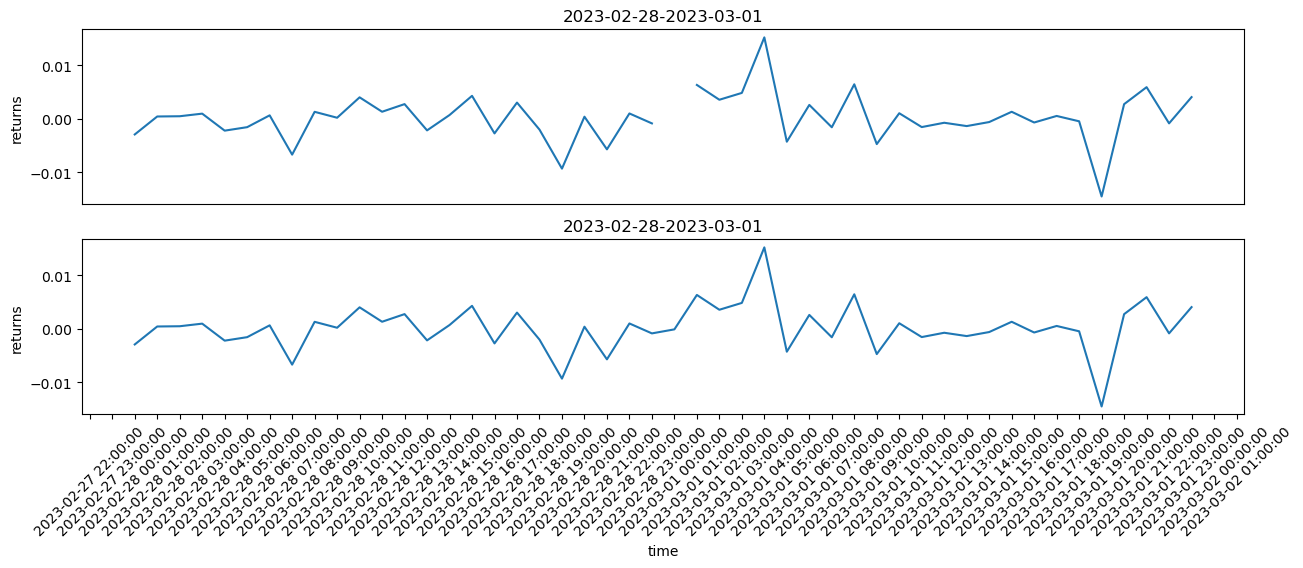

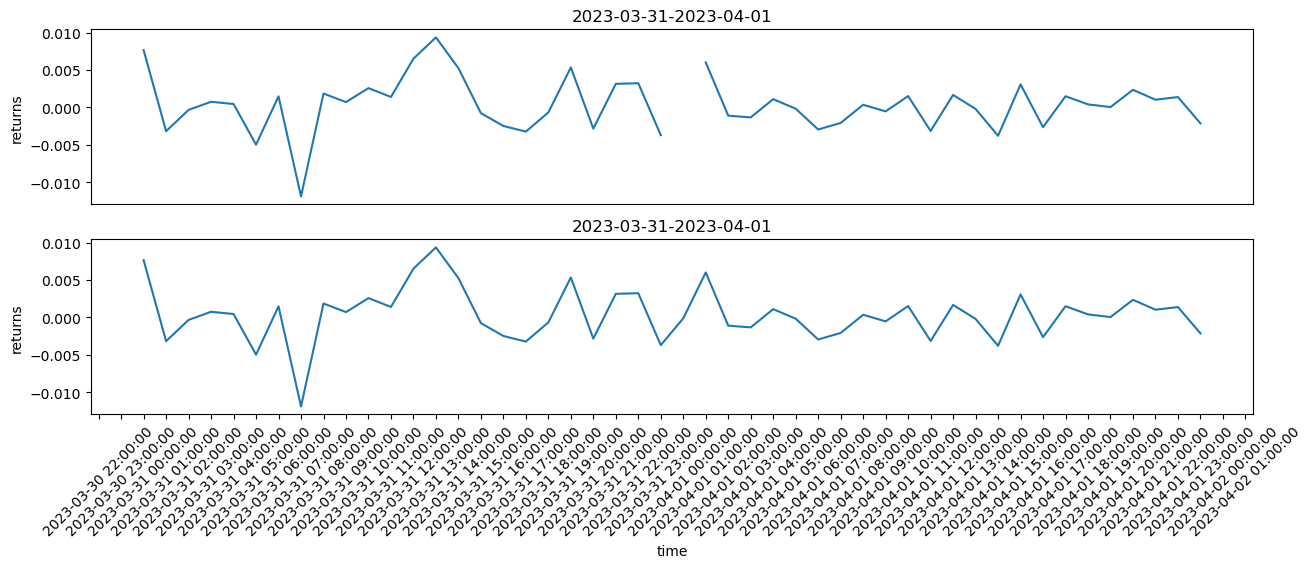

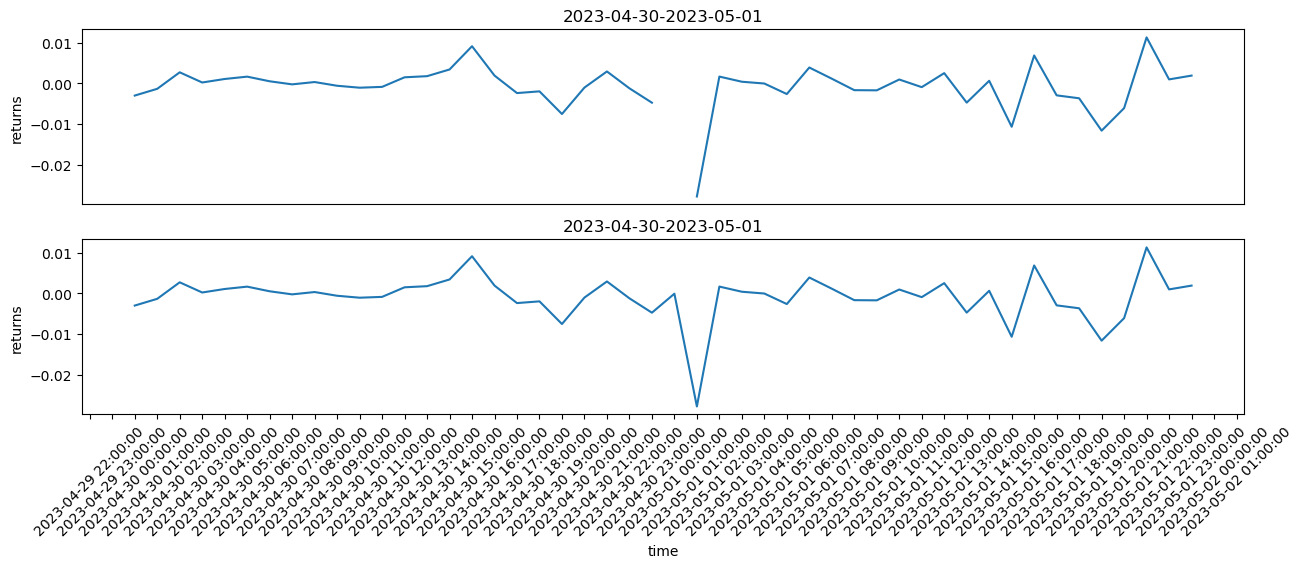

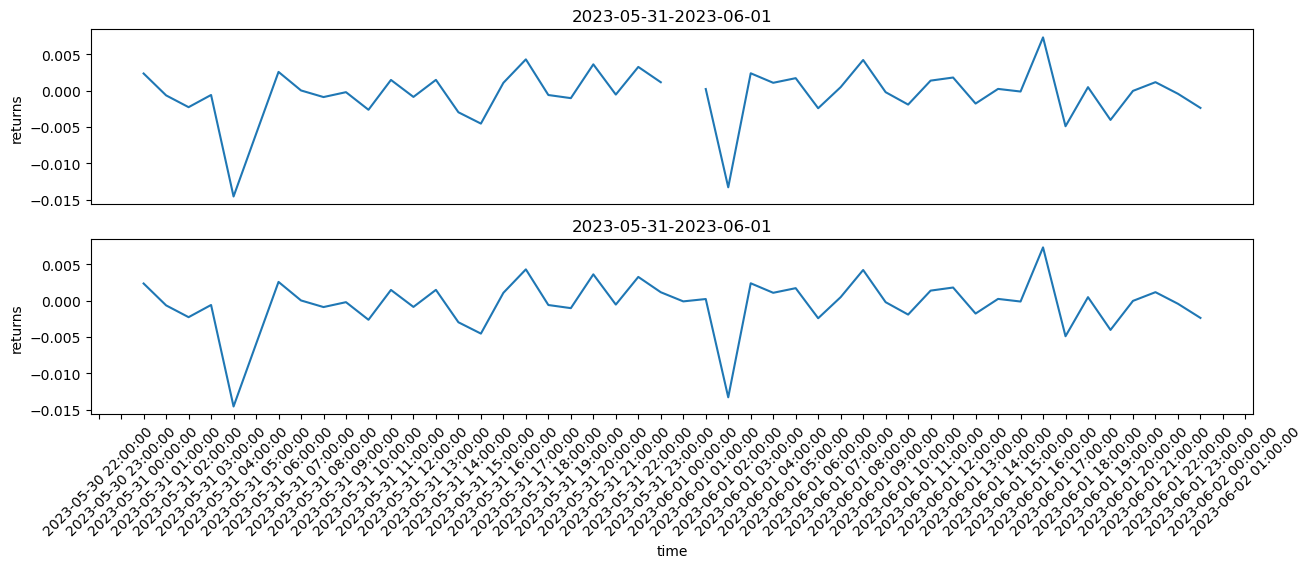

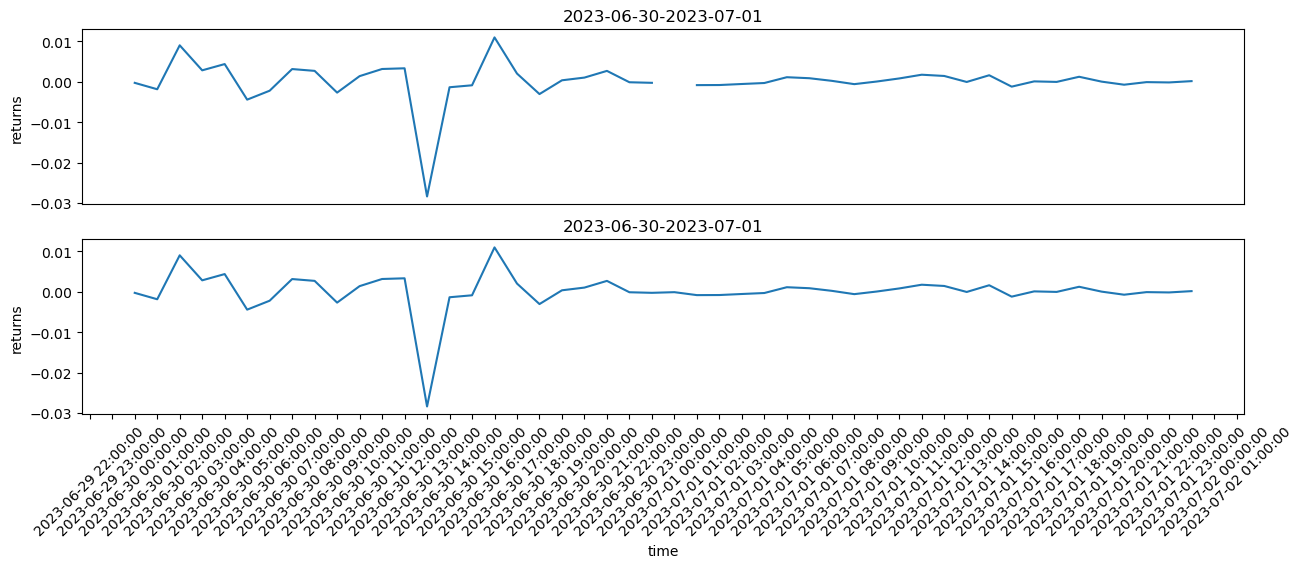

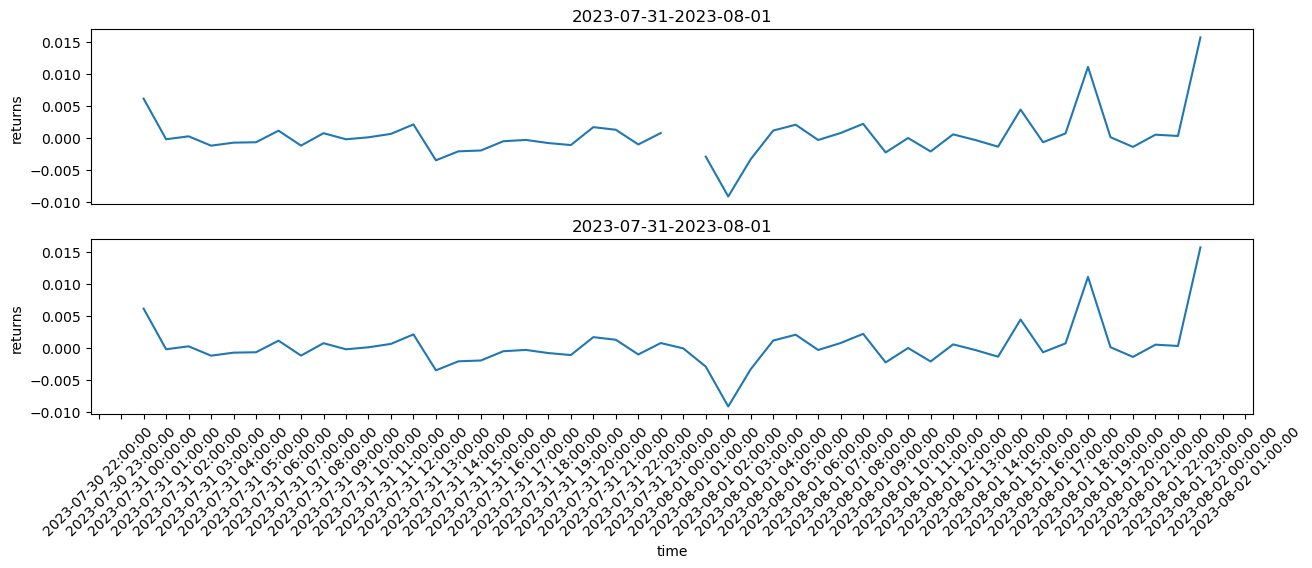

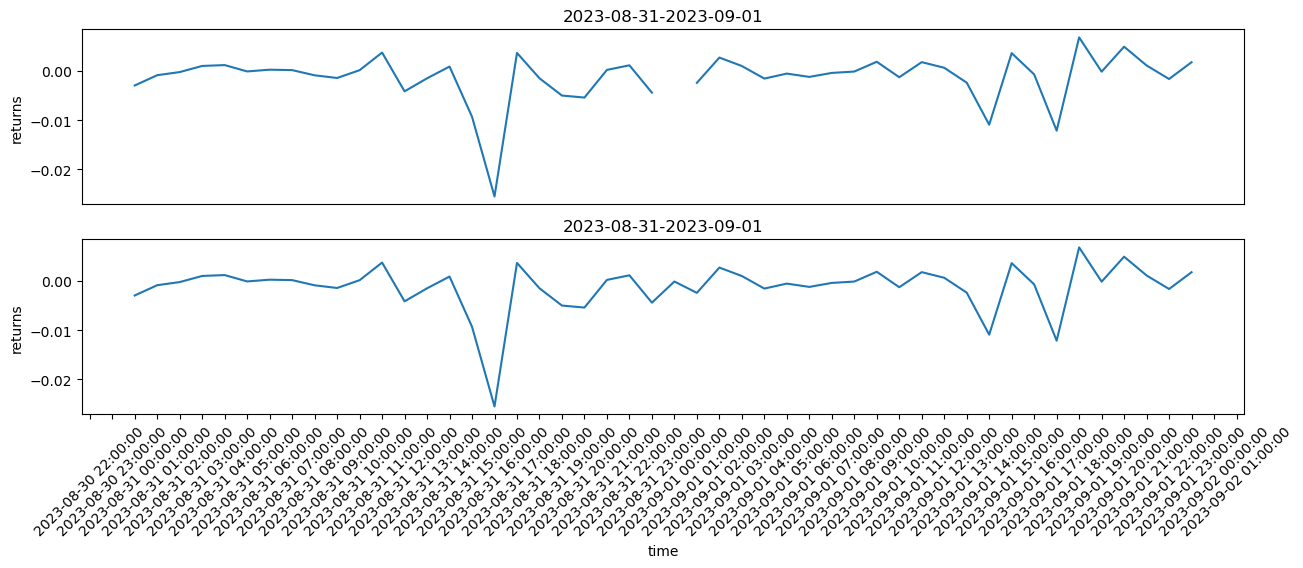

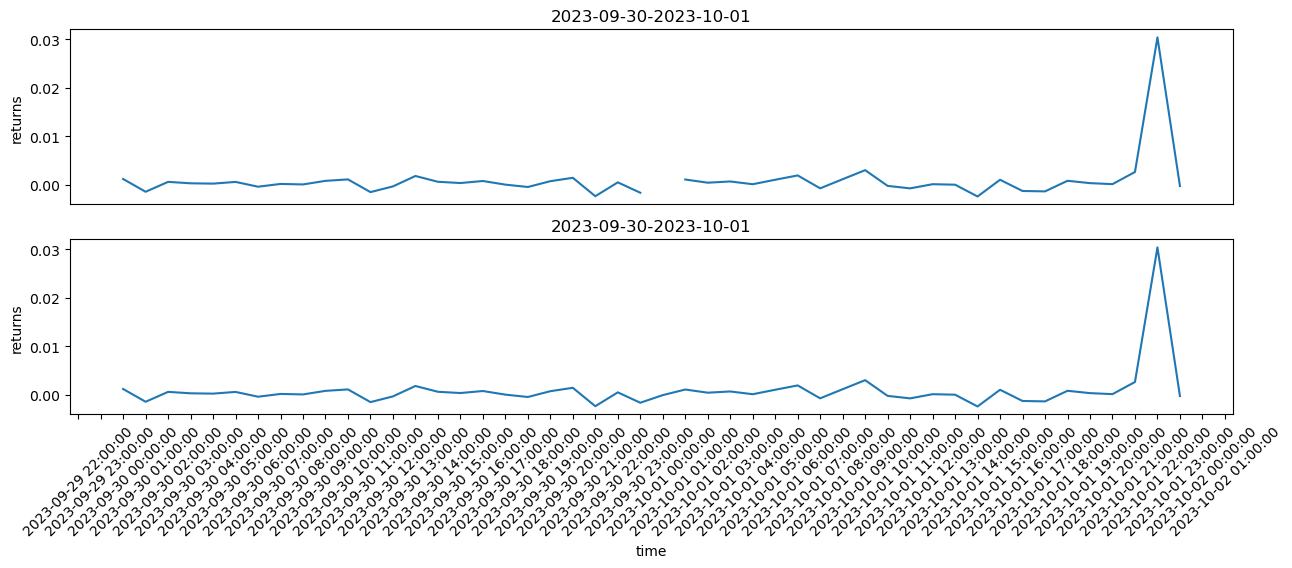

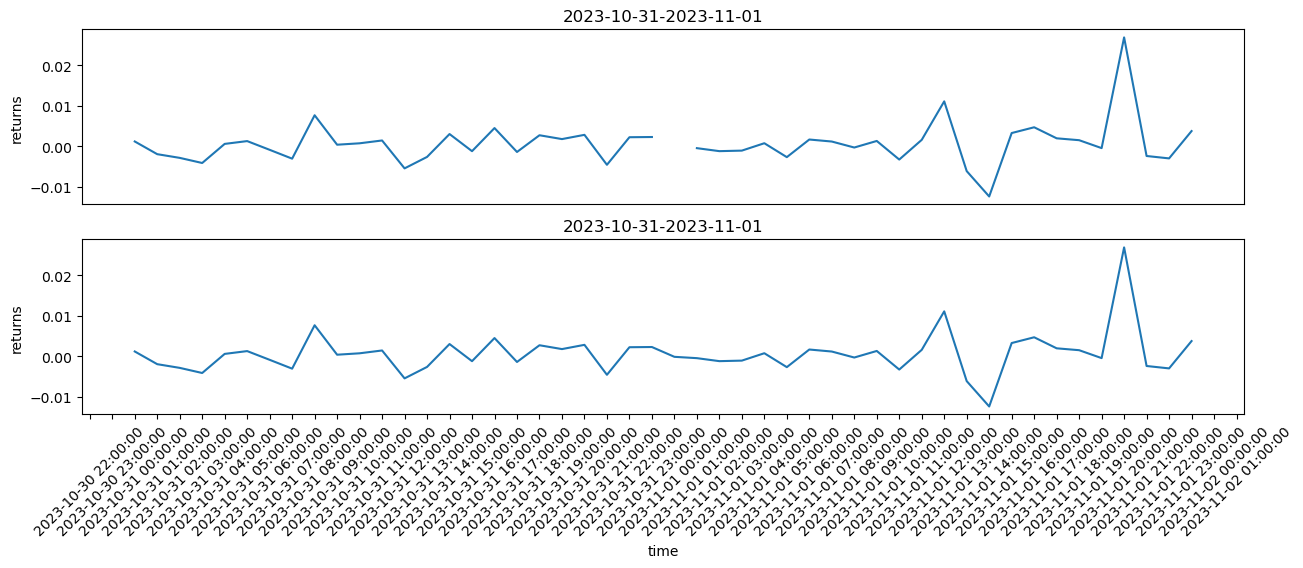

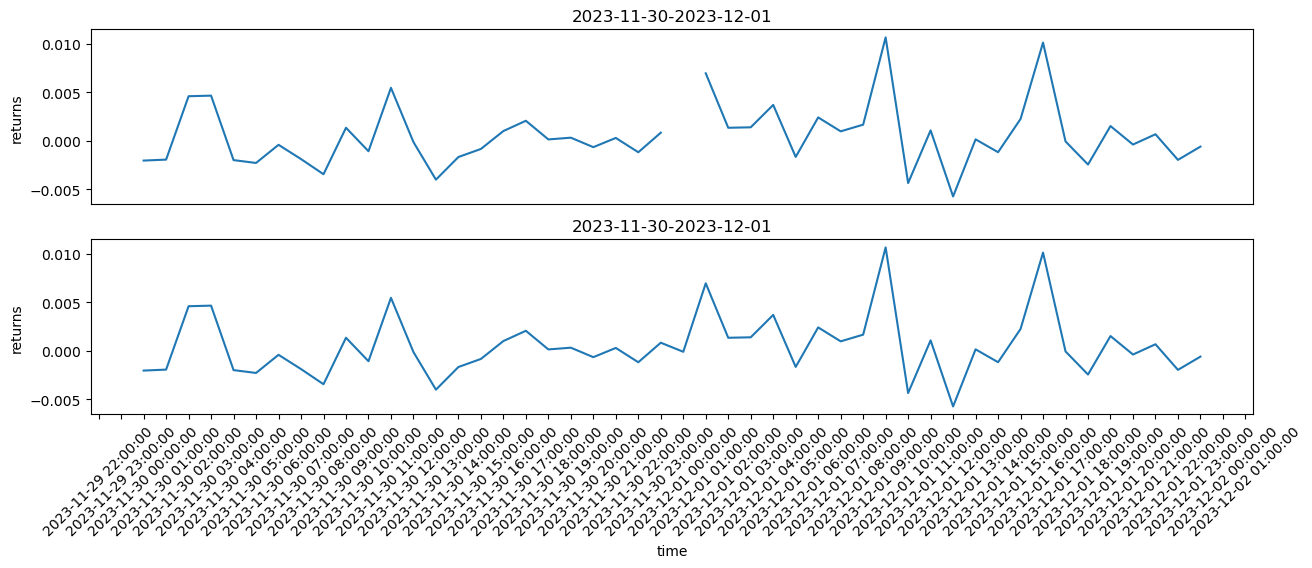

In [18]:
Visualizing_returns(dfc['returns'], df['returns'],'2023-01-31', '2023-02-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-02-28', '2023-03-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-03-31', '2023-04-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-04-30', '2023-05-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-05-31', '2023-06-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-06-30', '2023-07-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-07-31', '2023-08-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-08-31', '2023-09-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-09-30', '2023-10-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-10-31', '2023-11-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-11-30', '2023-12-01')

#### - volatility (interpolate_spline)

In [19]:
#spline_interpolate_column(df, 'volatility', order=3)

#### - volatility (Arima)

In [20]:
# auto_arima
df_returns_v = df['volatility'].dropna()
autoarima_model = pm.auto_arima(df_returns_v, suppress_warnings=True)
print(autoarima_model)

/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[0]          


/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [21]:
interpolate_arima(df['volatility'], (0, 1, 1))

/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

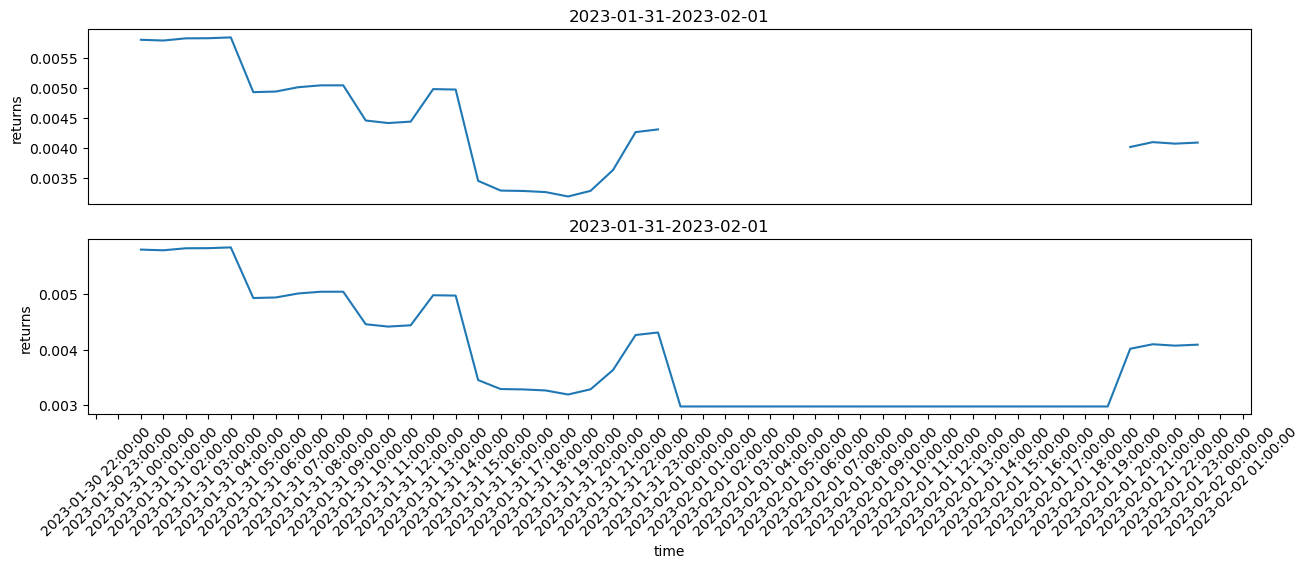

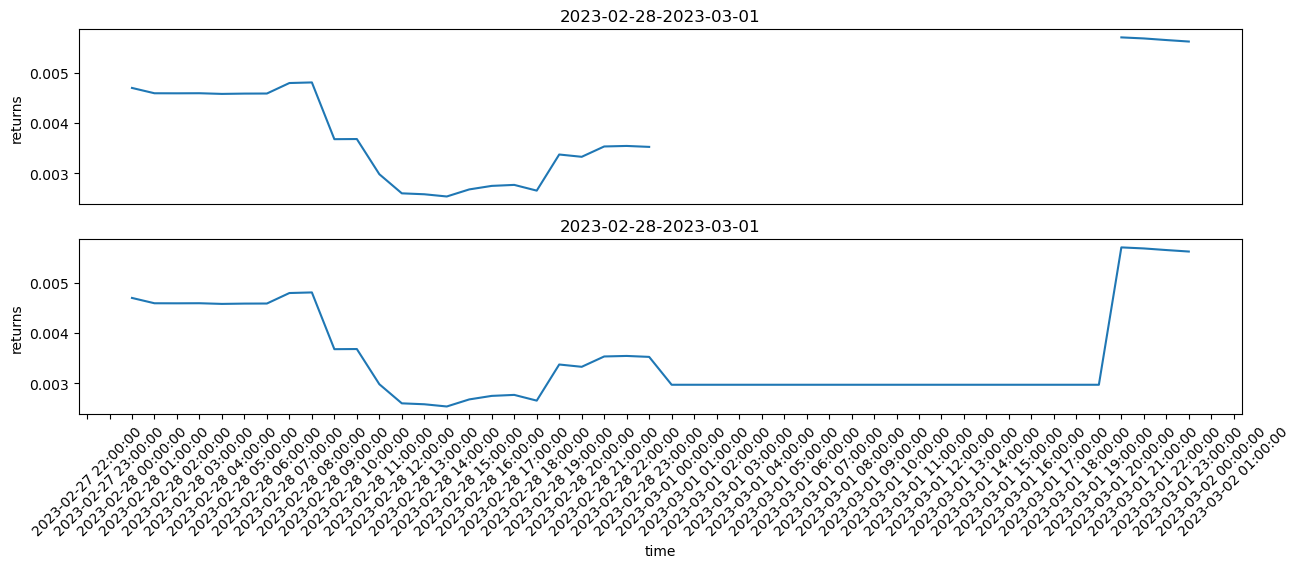

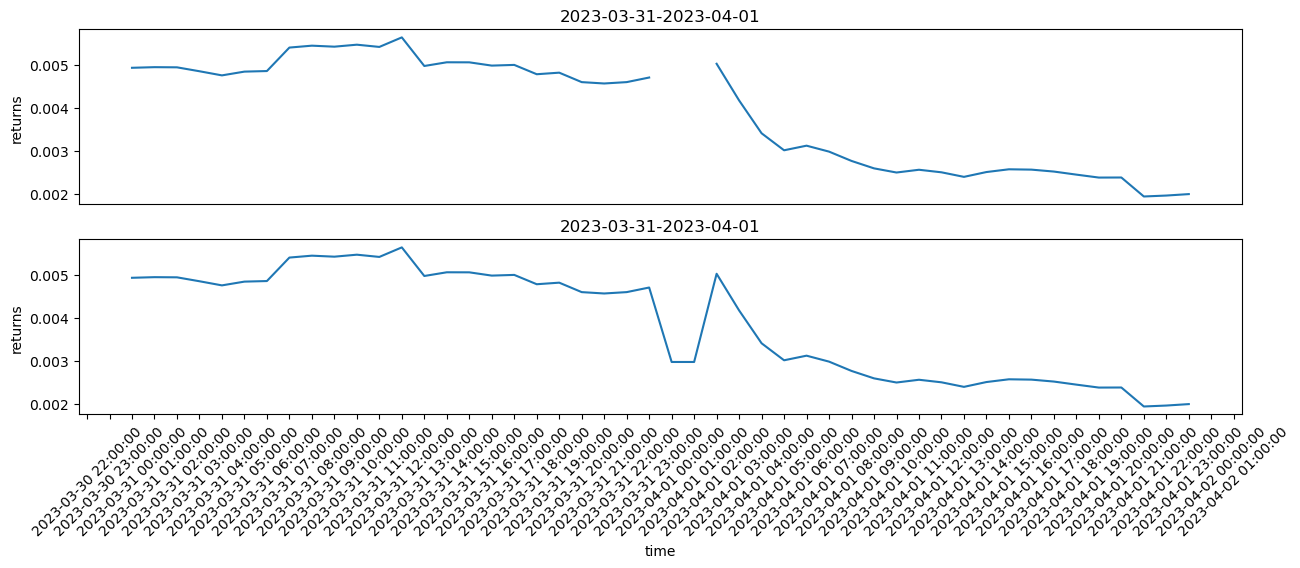

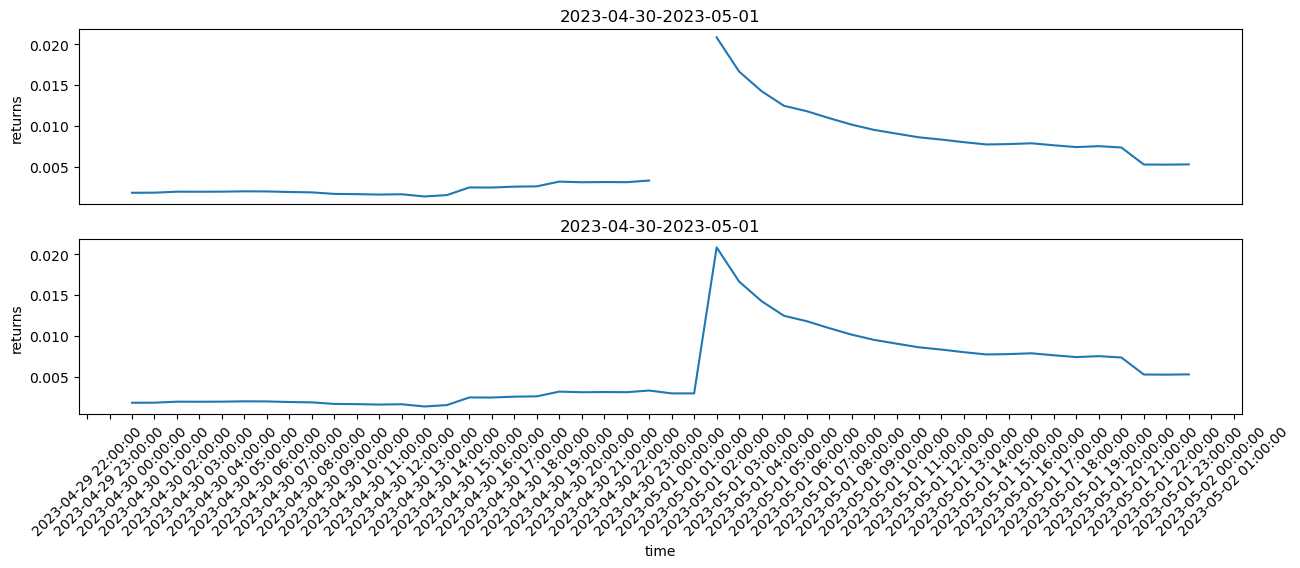

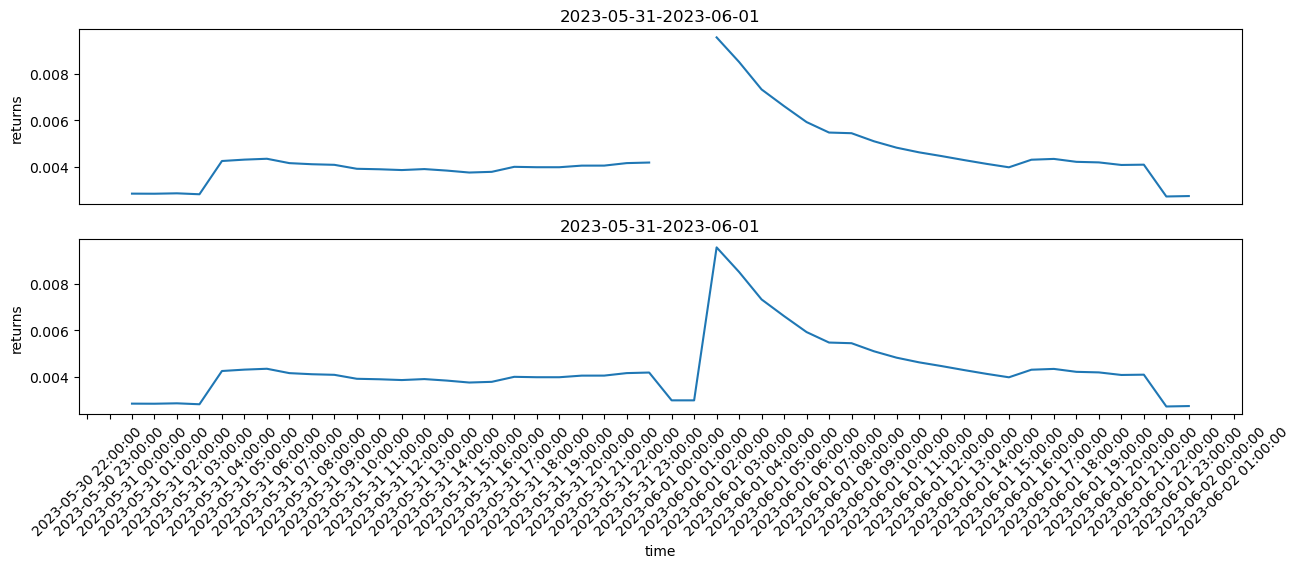

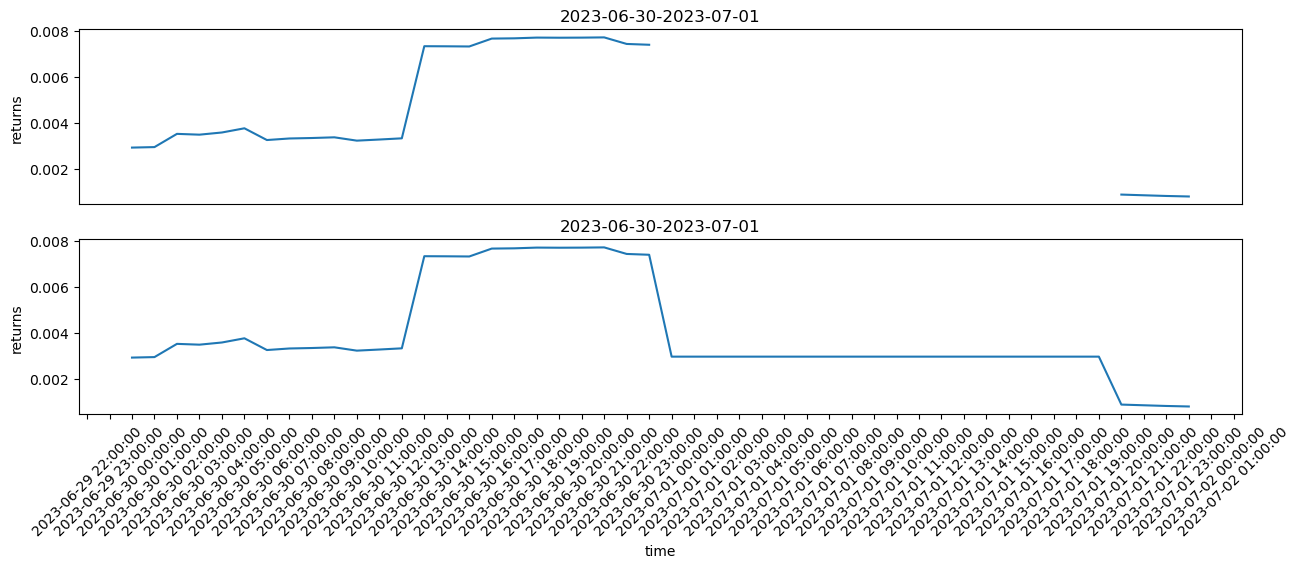

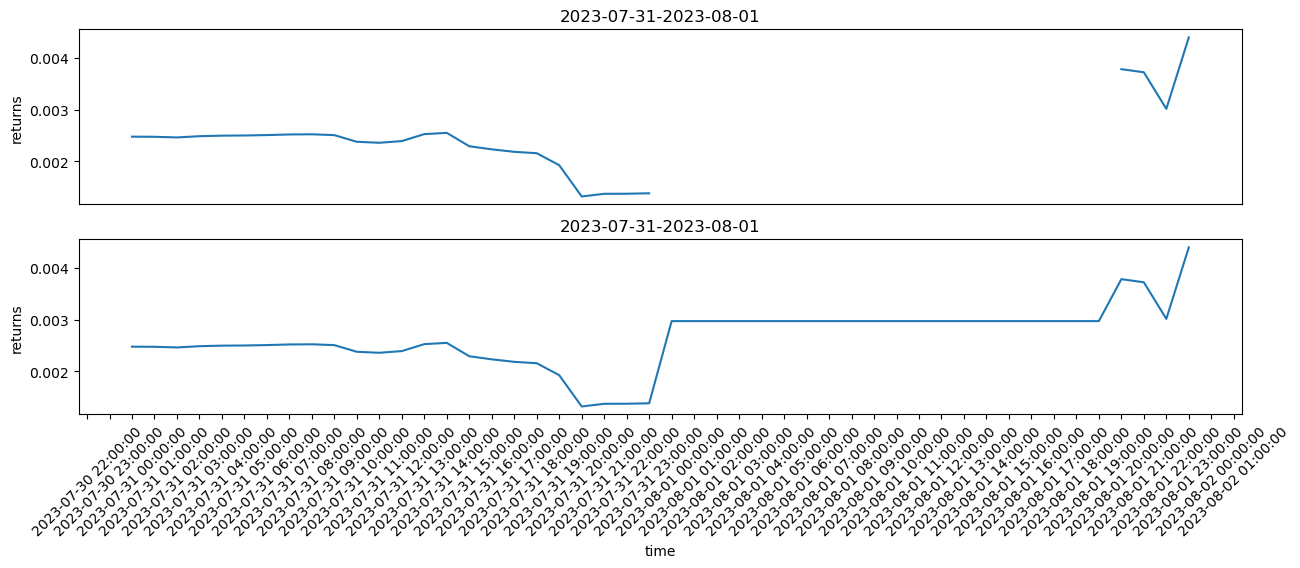

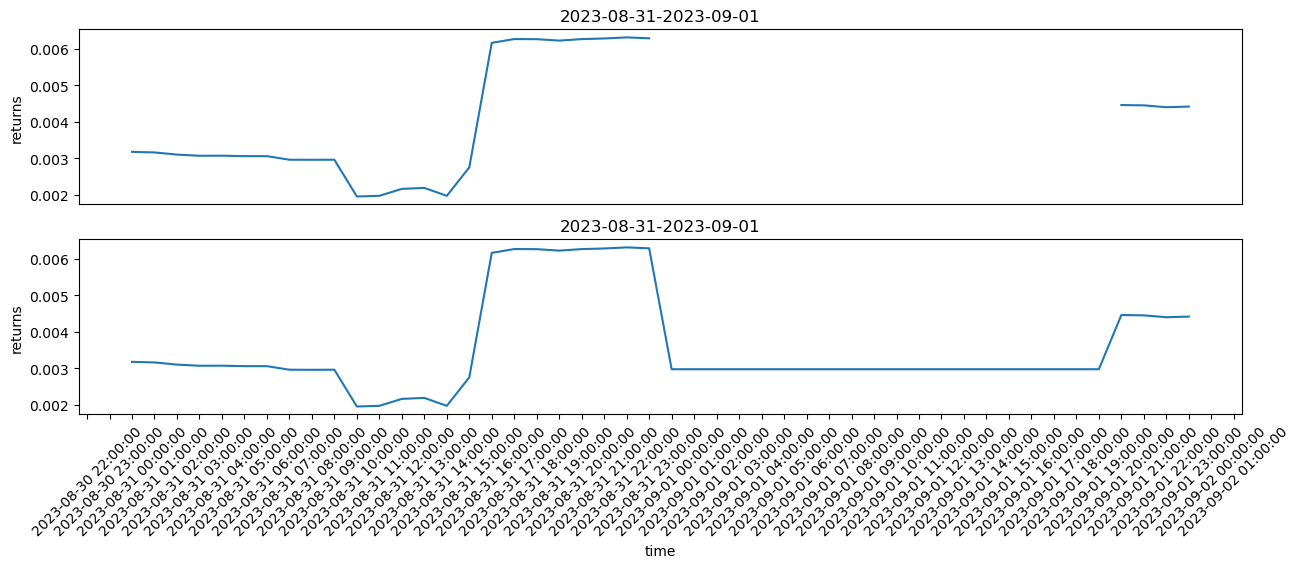

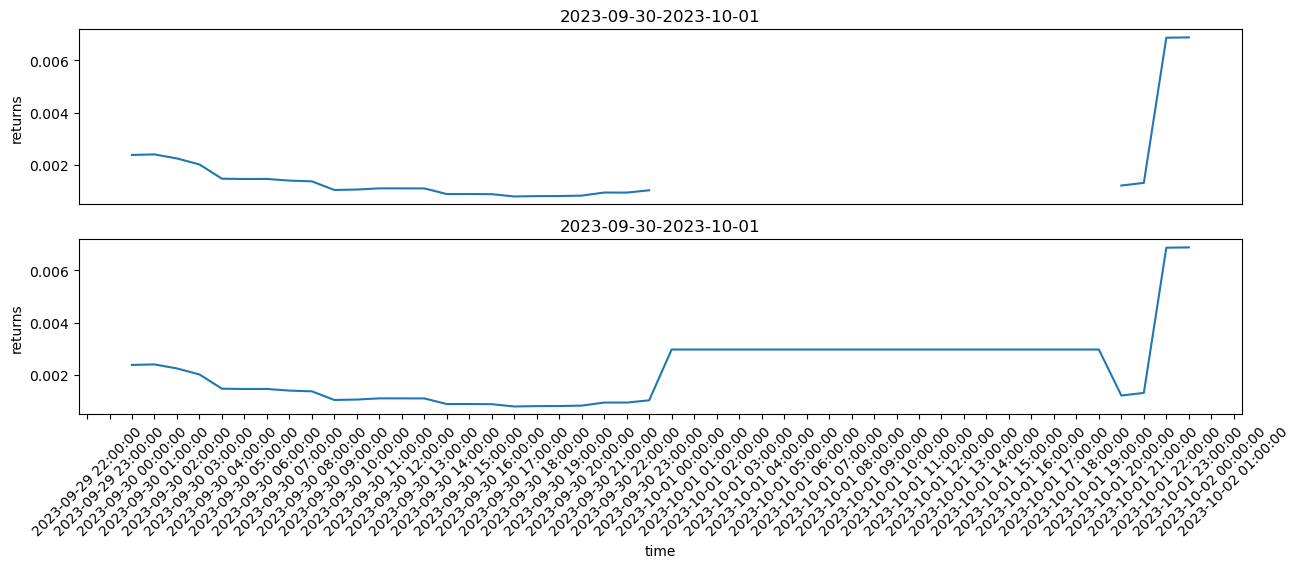

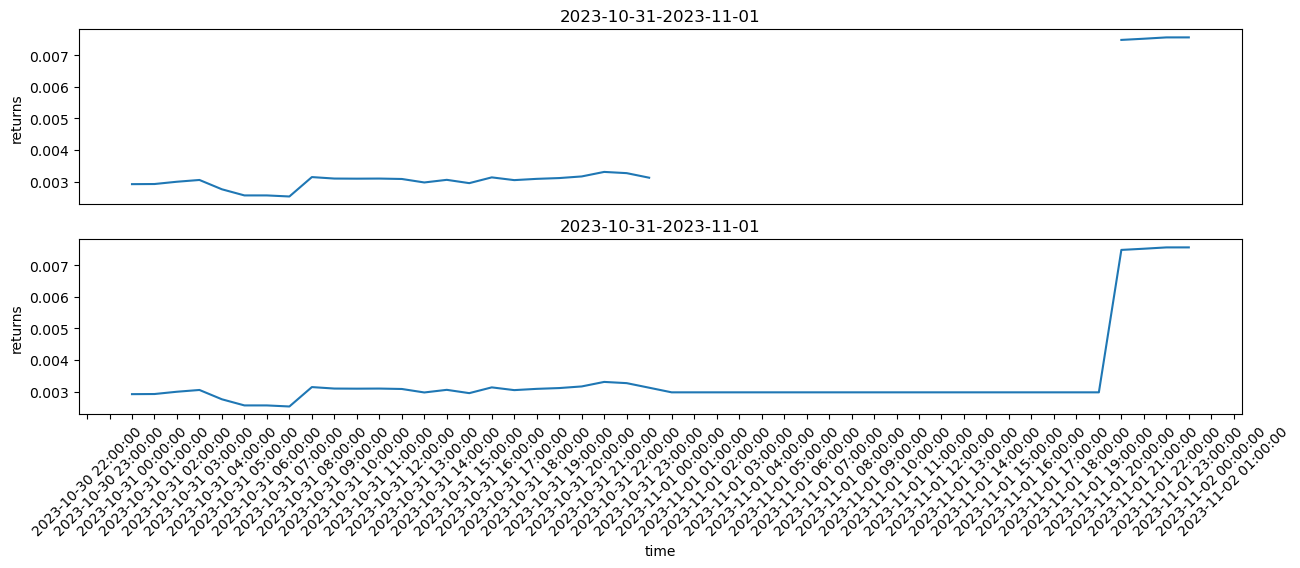

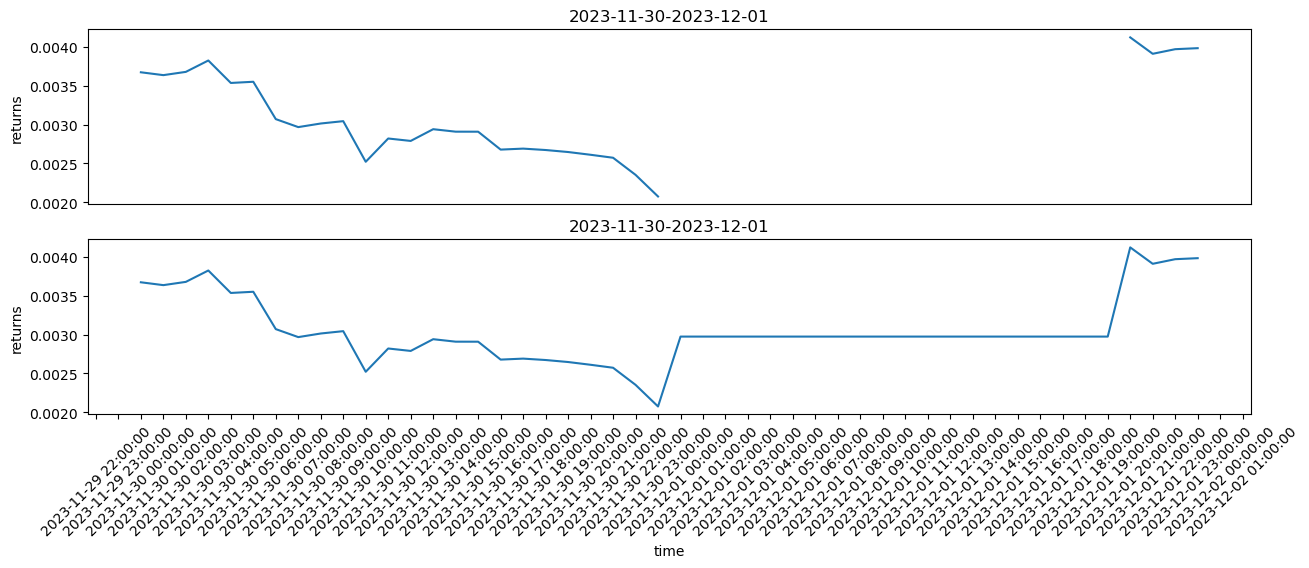

In [22]:
Visualizing_returns(dfc['volatility'], df['volatility'],'2023-01-31', '2023-02-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-02-28', '2023-03-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-03-31', '2023-04-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-04-30', '2023-05-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-05-31', '2023-06-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-06-30', '2023-07-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-07-31', '2023-08-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-08-31', '2023-09-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-09-30', '2023-10-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-10-31', '2023-11-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-11-30', '2023-12-01')

#### - volatility(GARCH)

In [23]:
# df[df['volatility'].isnull()].index # 매달 1일 20시간 결측(windows = 20)

In [24]:
# # 최적의 p,q 찾기 함수
# def interpolate_missing_values(df, column):
    
#     # 결측치 보간
#     returns = df[column]
#     interpolated_returns = returns.interpolate(method='linear')
#     df[column] = interpolated_returns

#     # 결측치 인덱스 추출
#     missing_indices = returns[returns.isna()].index

#     # 결측치 이전까지의 데이터 사용 - GARCH 모델 적합
#     model = arch.arch_model(returns.dropna(), vol='Garch', p=1, q=1)
#     model_fit = model.fit()

#     # 결측치 예측
#     forecasted_values = model_fit.forecast(start=missing_indices[0], horizon=len(missing_indices))

#     # 예측값 -> 결측치 위치에 대입해 보간
#     predicted_values = forecasted_values.mean.iloc[-1].values
#     returns.loc[missing_indices] = predicted_values

#     return df


# # 최적의 p,q 찾기 함수
# def find_optimal_pq(returns):
#     # 데이터 및 모델 정의
#     best_aic = float("inf")
#     best_bic = float("inf")
#     best_p = 0
#     best_q = 0
    
#     # p와 q의 후보값 설정
#     p_values = range(0, 5)  # p의 후보값 (0~4)
#     q_values = range(0, 5)  # q의 후보값 (0~4)

#     # 그리드 탐색
#     for p, q in itertools.product(p_values, q_values):
#         try:
#             model = arch.arch_model(returns, vol="Garch", p=p, q=q)
#             model_fit = model.fit(disp="off")
#             aic = model_fit.aic
#             bic = model_fit.bic
#             if aic < best_aic:
#                 best_aic = aic
#                 best_p = p
#                 best_q = q
#             if bic < best_bic:
#                 best_bic = bic
#                 best_p = p
#                 best_q = q
#         except:
#             continue

#     # 최적의 p와 q 값 출력
#     print("AIC를 기준으로 최적의 p와 q 값:", best_p, best_q)
#     print("BIC를 기준으로 최적의 p와 q 값:", best_p, best_q)
#     print('\n')
    
#     return best_p, best_q

# # GARCH 모델 생성 및 최적화 함수
# def simulate_garch_model(returns, p, q):
#     # GARCH 모델 생성 및 최적화
#     model = arch.arch_model(returns, vol='Garch', p=p, q=q)
#     model_fit = model.fit()

#     # 모델 시뮬레이션
#     nobs = len(returns)
#     simulated_data = model_fit.conditional_volatility[-nobs:] * np.random.normal(0, 1, nobs)

#     return simulated_data

In [25]:
# #'volatility' 컬럼의 결측치 보간
# df = interpolate_missing_values(df, 'volatility')

In [26]:
# best_p, best_q = find_optimal_pq(returns)
# simulated_data = simulate_garch_model(returns, best_p, best_q)
# print(simulated_data)

In [27]:
# Visualizing_returns(dfc['volatility'], df['volatility'],'2023-01-31', '2023-02-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-02-28', '2023-03-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-03-31', '2023-04-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-04-30', '2023-05-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-05-31', '2023-06-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-06-30', '2023-07-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-07-31', '2023-08-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-08-31', '2023-09-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-09-30', '2023-10-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-10-31', '2023-11-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-11-30', '2023-12-01')

### 2-1. Baseline Model Genarate

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rf_base(train_df, test_df, df_name=''): 
    # Train/Test Split
    X_train = train_df.drop('volatility', axis=1)
    y_train = train_df['volatility']
    
    X_test = test_df.drop('volatility', axis=1)
    y_test = test_df['volatility']

    # RandomForestRegressor
    rf_model = RandomForestRegressor(max_depth=15,
                                     max_features=0.2,
                                     n_estimators=400,
                                     random_state=42)  # random_state 추가

    # 모델 학습
    rf_model.fit(X_train, y_train)

    # 예측
    y_pred = rf_model.predict(X_test)

    # 평가지표(MAPE, RMSE)
    test_mape = calculate_mape(y_test, y_pred)
    test_rmse = calculate_rmse(y_test, y_pred)
    print(f'{df_name} : MAPE: {test_mape}, RMSE: {test_rmse}')

- Baseline Model test(테스트용)

In [30]:
# df 모델링
df_tr, df_te = train_test_split(df, test_size=0.2, random_state=42)
rf_base(df_tr, df_te, 'df_tr')

df_tr : MAPE: 41.25415007497947, RMSE: 0.0018482293608570292


n_estimators 값에 따라 평가지표 값에 유의한 차이가 없음

### 2-3. Technical Indicators

#### MACD Function (Moving Average Convergence Divergence)
Calculates the difference between short-term and long-term moving averages to indicate trends.
Quickly detects trends but may be sensitive to noise.
#### Stochastic Oscillator Function
An indicator that reflects the trend of price fluctuations in financial markets such as stocks.
Calculates the relative strength of the price based on the highest (High) and lowest (Low) prices over the last N days.
#### ATR Function (Average True Range)
An indicator that represents the average range of price movements.
Calculates volatility using True Range.
#### Bollinger Bands Function
An indicator that uses moving averages and standard deviation to assess the relative height of prices.
Forms upper and lower bands around the moving average, indicating deviations in stock prices.
#### ROC Function (Rate of Change)
Measures the relative price change over a certain period.
Analyzes the flow of stock prices by comparing the current price with the price a certain period ago.
#### RSI Function (Relative Strength Index)
Relative Strength Index indicating the relative strength of price movements over a specific period.
Generally, values above 70 indicate an uptrend, while values below 30 indicate a downtrend.
#### Ultimate Oscillator Function
A comprehensive indicator that combines relative strength for various periods.
Provides a richer analysis of the stock price trend.

###  2-3-1. Technical Indicators - functions

In [42]:
# MACD 함수
def MACD(data, short_window, long_window, signal_window):
    
    data[f'Short_MA_{short_window}'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data[f'Long_MA_{long_window}'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data[f'MACD_{short_window}{long_window}'] = data[f'Short_MA_{short_window}'] - data[f'Long_MA_{long_window}']
    data[f'Signal_Line_{signal_window}'] = data[f'MACD_{short_window}{long_window}'].ewm(span=signal_window, adjust=False).mean()
    data[f'MACD_Oscillator_{short_window}{long_window}'] = data[f'MACD_{short_window}{long_window}'] - data[f'Signal_Line_{signal_window}']
    
    data.drop([f'Short_MA_{short_window}', f'Long_MA_{long_window}'], axis=1, inplace=True)
    
    return data
    
    
# Stochastic Oscillator 함수
def cal_stoc_os(df, period, m):
    
    # 최근 N일간의 최고가(H)와 최저가(L)
    df[f'SO high_{period}{m}'] = df['High'].rolling(window=period).max()
    df[f'SO low_{period}{m}'] = df['Low'].rolling(window=period).min()
    
    # %K 계산
    df[f'SO %K_{period}{m}'] = (df['Close'] - df[f'SO low_{period}{m}']) / (df[f'SO high_{period}{m}'] - df[f'SO low_{period}{m}']) * 100
    
    # %D 계산
    df[f'SO %D_{period}{m}'] = df[f'SO %K_{period}{m}'].rolling(m).mean()
    
    return df
    
    
# ATR 함수
def calculate_atr(df, period):
    # True Range 계산
    df['high-low'] = df['High'] - df['Low']
    df['high-close'] = abs(df['High'] - df['Close'].shift())
    df['low-close'] = abs(df['Low'] - df['Close'].shift())
    
    df['true_range'] = df[['high-low', 'high-close', 'low-close']].max(axis=1)
    
    # ATR 계산
    df[f'atr_{period}'] = df['true_range'].rolling(window=period, min_periods=1).mean()
    
    # 임시 열 삭제
    df.drop(['high-low', 'high-close', 'low-close', 'true_range'], axis=1, inplace=True)
    
    return df


# Bollinger_band 함수
def bollinger_bands(df, window, num_std_dev):
    
    # 이동평균 계산
    df['rolling_mean'] = df['price'].rolling(window=window).mean()

    # 표준편차 계산
    df['rolling_std'] = df['price'].rolling(window=window).std()

    # 볼린저 밴드 상단 및 하단 계산
    df[f'upper_band_{window}'] = df['rolling_mean'] + (num_std_dev * df['rolling_std'])
    df[f'lower_band_{window}'] = df['rolling_mean'] - (num_std_dev * df['rolling_std'])

    # 필요없는 컬럼 삭제
    df.drop(['rolling_mean', 'rolling_std'], axis=1, inplace=True)

    return df


# ROC 계산 함수
def calculate_roc(df, close_column, timeperiod):
    prev_close = df[close_column].shift(timeperiod)
    df[f'roc_{timeperiod}'] = ((df[close_column] - prev_close) / prev_close) * 100
    
    return df


# RSI 계산 함수
def calculate_rsi(df, close_column, timeperiod):
    delta = df[close_column].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=timeperiod, min_periods=1).mean()
    avg_loss = loss.rolling(window=timeperiod, min_periods=1).mean()

    rs = avg_gain / avg_loss
    df[f'rsi_{timeperiod}'] = 100 - (100 / (1 + rs))
    
    return df


# Ultimate Oscillator 함수
def calculate_uo(df, period1, period2, period3):
    # True Range 계산
    df['true_range'] = df['High'].combine(df['Close'].shift(1), max) - df['Low'].combine(df['Close'].shift(1), min)
    
    # Average True Range (ATR) 계산
    df['avg_true_range1'] = df['true_range'].rolling(window=period1, min_periods=1).mean()
    df['avg_true_range2'] = df['true_range'].rolling(window=period2, min_periods=1).mean()
    df['avg_true_range3'] = df['true_range'].rolling(window=period3, min_periods=1).mean()

    # Buying Pressure 계산
    df['buying_pressure'] = df['Close'] - df[['Open', 'Close']].min(axis=1)

    # True Buying Pressure (TBP) 계산
    df['true_buying_pressure1'] = df['buying_pressure'].rolling(window=period1, min_periods=1).sum()
    df['true_buying_pressure2'] = df['buying_pressure'].rolling(window=period2, min_periods=1).sum()
    df['true_buying_pressure3'] = df['buying_pressure'].rolling(window=period3, min_periods=1).sum()

    # UO 계산
    df[f'UO_{period1}{period2}{period3}'] = (
        100
        * (4 * df['true_buying_pressure1'] / df['avg_true_range1'])
        + 2 * (4 * df['true_buying_pressure2'] / df['avg_true_range2'])
        + (df['true_buying_pressure3'] / df['avg_true_range3'])
    ) / (4 + 2 + 1)

    # 필요 없는 열 제거
    df = df.drop(['true_range', 'avg_true_range1', 'avg_true_range2', 'avg_true_range3',
                  'buying_pressure', 'true_buying_pressure1', 'true_buying_pressure2', 'true_buying_pressure3'], axis=1)

    return df

### 2-3-2. Technical Indicators - Optimization

1. 결측치
2. 평가지표 비교
* 수익률: 볼린저 밴드를 기반으로 한 수익률을 평가하는 지표로, 해당 지표가 가격의 특이값을 얼마나 잘 캐치하고 이에 따른 수익을 얼마나 창출하는지를 측정.
* 변동성: 볼린저 밴드를 기반으로 주가의 변동성을 얼마나 잘 포착하는지를 확인하는 지표
* 최대 손실: 볼린저 밴드를 기반으로 투자 전략이 어떤 상황에서 최대 손실을 겪는지 확인하는 지표
* 승률: 볼린저 밴드의 신호가 실제로 가격의 특이값을 잘 나타내고 있는지 확인하는 지표로, 해당 기준은 상한선('upper_band')를 넘는 경우를 '승리'로 간주.

##### Stochastic Oscillator
일반적으로는 14와 3을 사용한다. 
- period의 경우, 주가 데이터의 기간에 따라 최적의 값을 설정할 수 있다. 예를 들어, 10일, 30일, 50일 등 다양한 기간을 선택할 수 있다.
- m은 %K의 이동평균을 계산하는데 사용되는 기간이다. 따라서, 2, 5, 10 등 다른 값을 설정할 수도 있다.
> 주가 데이터의 특성과 분석 목적에 따라 period와 m의 값을 조정하여 최적의 결과를 얻을 수 있다

In [43]:
# 평가 지표를 저장 딕셔너리
evaluation_results = {}

# period와 m의 다양한 조합 설정
periods = [14, 20, 30]  # 다양한 period
ms = [2, 3, 5, 10]  # 다양한 m

# 각 조합 평가 지표 계산
for period in periods:
    for m in ms:
        df_copy = df.copy()
        df_copy = cal_stoc_os(df_copy, period=period, m=m)
        
        # 평가 지표 계산 (수익률, 변동성, 최대 손실, 승률)
        returns = df_copy['Close'].pct_change().cumsum().iloc[-1]
        volatility = df_copy['Close'].pct_change().std() 
        max_drawdown = (df_copy['Close'].cummax() - df_copy['Close']).max()
        win_rate = (df_copy[f'SO %K_{period}{m}'] > df_copy[f'SO %D_{period}{m}']).mean()
        
        # 결측치 계산
        k_na = df_copy[f'SO %K_{period}{m}'].isna().sum()  # 수정된 부분
        d_na = df_copy[f'SO %D_{period}{m}'].isna().sum()  # 수정된 부분
        
        # 평가 지표 -> 딕셔너리에 저장
        evaluation_results[(period, m)] = {
            'Returns': returns,
            'Volatility': volatility,
            'Max Drawdown': max_drawdown,
            'Win Rate': win_rate,
            'k_na': k_na,
            'd_na': d_na
            
        }

# 평가 지표를 기준으로 가장 좋은 조합?
best_combination = max(evaluation_results, key=lambda x: evaluation_results[x]['Returns'])

# 결과
print("Evaluation Results:")
for combination, metrics in evaluation_results.items():
    print(f"Period={combination[0]}, m={combination[1]}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()

print("Best Combination:")
print(f"Period={best_combination[0]}, m={best_combination[1]}")


Evaluation Results:
Period=14, m=2
Returns: 1.0307571629755363
Volatility: 0.004548613868554929
Max Drawdown: 6592.299999999999
Win Rate: 0.507648401826484
k_na: 13
d_na: 14

Period=14, m=3
Returns: 1.0307571629755363
Volatility: 0.004548613868554929
Max Drawdown: 6592.299999999999
Win Rate: 0.5021689497716895
k_na: 13
d_na: 15

Period=14, m=5
Returns: 1.0307571629755363
Volatility: 0.004548613868554929
Max Drawdown: 6592.299999999999
Win Rate: 0.49920091324200916
k_na: 13
d_na: 17

Period=14, m=10
Returns: 1.0307571629755363
Volatility: 0.004548613868554929
Max Drawdown: 6592.299999999999
Win Rate: 0.5050228310502283
k_na: 13
d_na: 22

Period=20, m=2
Returns: 1.0307571629755363
Volatility: 0.004548613868554929
Max Drawdown: 6592.299999999999
Win Rate: 0.5047945205479452
k_na: 19
d_na: 20

Period=20, m=3
Returns: 1.0307571629755363
Volatility: 0.004548613868554929
Max Drawdown: 6592.299999999999
Win Rate: 0.5003424657534247
k_na: 19
d_na: 21

Period=20, m=5
Returns: 1.0307571629755363


##### Boolinger Band
일반적으로 20일과 2배수를 사용

* window 값 설정은 주가의 변동을 얼마나 민감하게 볼 것인가에 따라 결정함

  기본값 : 20일이며, 10일~50일 사이의 값

  작은 값으로 설정 시 짧은 주기 동안의 가격 움직임을 빠르게 파악할 수 있고, 큰 값 설정 시 긴 주기의 추세를 부드럽게 나타낼 수 있습니다.

* 표준편차 배수 설정은 주가의 움직임을 어느 폭까지 감지할 것인가에 따라 결정할 수 있습니다.

  기본값은 2이고, 1.5 또는 2 값이 적절합니다.

  작은 값 설정 시 움직임을 파악하는 폭이 좁아져서 특이한 움직임이나 극단적인 상황을 감지하기 어렵고, 큰 값 설정 시 큰 변동성을 감지하기 용이합니다.

> **표준편차 배수 : 1.5와 2 확인 필요.**

> **window 값 : 짧은 주기 설정이 필요하다는 판단 하에 10일, 15일, 20일 경우 확인.**

> window 값이 10이고 표준편차 배수가 1.5일 때 가장 적음

In [44]:
# 평가 지표 저장 딕셔너리 생성
evaluation_results = {}

# 가능한 조합의 평가 지표(수익률, 변동성, 최대 손실, 승률) 계산
for window in [10, 15, 20]:
    for num_std_dev in [1.5, 2]:
        
        # 볼린저 밴드 생성 및 조합 적용
        df_copy = df.copy()
        df_copy = bollinger_bands(df_copy, window=window, num_std_dev=num_std_dev)
        
        # 평가 지표 계산
        returns = df_copy['Close'].pct_change().cumsum().iloc[-1]
        volatility = df_copy['Close'].pct_change().std()
        max_drawdown = (df_copy['Close'].cummax() - df_copy['Close']).max()
        win_rate = (df_copy['Close'] > df_copy[f'upper_band_{window}']).mean()
    
        # 결측치 여부 확인
        upper_band_na = df_copy[f'upper_band_{window}'].isna().sum()
        lower_band_na = df_copy[f'lower_band_{window}'].isna().sum()
        
        # 평가 지표 및 결측치 저장
        evaluation_results[(window, num_std_dev)] = {
            'Returns': returns,
            'Volatility': volatility,
            'Max Drawdown': max_drawdown,
            'Win Rate': win_rate,
            'Upper Band NA': upper_band_na,
            'Lower Band NA': lower_band_na
        }

# 가장 좋은 조합 찾기(returns 기준)
best_combination = max(evaluation_results, key=lambda x: evaluation_results[x]['Returns'])

# 결과 출력
print("Evaluation Results:")
for combination, metrics in evaluation_results.items():
    print(f"window={combination[0]}, num_std_dev={combination[1]}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()

print("Best Combination:")
print(f"window={best_combination[0]}, num_std_dev={best_combination[1]}")


Evaluation Results:
window=10, num_std_dev=1.5
Returns: 1.0307571629755363
Volatility: 0.004548613868554929
Max Drawdown: 6592.299999999999
Win Rate: 0.14052511415525115
Upper Band NA: 9
Lower Band NA: 9

window=10, num_std_dev=2
Returns: 1.0307571629755363
Volatility: 0.004548613868554929
Max Drawdown: 6592.299999999999
Win Rate: 0.07374429223744292
Upper Band NA: 9
Lower Band NA: 9

window=15, num_std_dev=1.5
Returns: 1.0307571629755363
Volatility: 0.004548613868554929
Max Drawdown: 6592.299999999999
Win Rate: 0.14874429223744293
Upper Band NA: 14
Lower Band NA: 14

window=15, num_std_dev=2
Returns: 1.0307571629755363
Volatility: 0.004548613868554929
Max Drawdown: 6592.299999999999
Win Rate: 0.08162100456621005
Upper Band NA: 14
Lower Band NA: 14

window=20, num_std_dev=1.5
Returns: 1.0307571629755363
Volatility: 0.004548613868554929
Max Drawdown: 6592.299999999999
Win Rate: 0.15148401826484018
Upper Band NA: 19
Lower Band NA: 19

window=20, num_std_dev=2
Returns: 1.0307571629755363


### 2-3-3. Technical Indicators - Generation

In [45]:
# df와 df_idc의 구분을 위한 copy
df_copy=df.copy()

In [46]:
df_idc = MACD(df_copy, 6, 13, 4) # 단기추세 감지 but 노이즈에 민감할 가능성 있음
df_idc = MACD(df_idc, 12, 26, 9) # 일반적인 window 계수 but 변동성이 큰 시장에선 느리게 반응할 수 있음
df_idc = MACD(df_idc, 5, 26, 9) 

df_idc = calculate_atr(df_idc, period=14) 
df_idc = calculate_atr(df_idc, period=20)

df_idc = cal_stoc_os(df_idc, period=20, m=2)
df_idc = cal_stoc_os(df_idc, period=14, m=2)
df_idc = cal_stoc_os(df_idc, period=30, m=2)

df_idc = cal_stoc_os(df_idc, period=20, m=3)
df_idc = cal_stoc_os(df_idc, period=14, m=3)
df_idc = cal_stoc_os(df_idc, period=30, m=3)

df_idc = cal_stoc_os(df_idc, period=20, m=5)
df_idc = cal_stoc_os(df_idc, period=14, m=5)
df_idc = cal_stoc_os(df_idc, period=30, m=5)

df_idc = cal_stoc_os(df_idc, period=20, m=10)
df_idc = cal_stoc_os(df_idc, period=14, m=10)
df_idc = cal_stoc_os(df_idc, period=30, m=10)

df_idc = bollinger_bands(df_idc, window=20, num_std_dev=1.5)
df_idc = bollinger_bands(df_idc, window=15, num_std_dev=1.5)
df_idc = bollinger_bands(df_idc, window=10, num_std_dev=1.5)
df_idc = bollinger_bands(df_idc, window=20, num_std_dev=2)
df_idc = bollinger_bands(df_idc, window=15, num_std_dev=2)
df_idc = bollinger_bands(df_idc, window=10, num_std_dev=2)

df_idc = calculate_roc(df_idc, close_column='Close', timeperiod=1)
df_idc = calculate_roc(df_idc, close_column='Close', timeperiod=2)

df_idc = calculate_rsi(df_idc, close_column='Close', timeperiod=7)
df_idc = calculate_rsi(df_idc, close_column='Close', timeperiod=9)
df_idc = calculate_rsi(df_idc, close_column='Close', timeperiod=14)

df_idc_all = calculate_uo(df_idc, 7, 10, 14)
df_idc_all = calculate_uo(df_idc, 7, 9, 11)
df_idc_all = calculate_uo(df_idc, 7, 10, 12)

In [47]:
#  'true_range', 'avg_true_range1', 'avg_true_range2',
#        'avg_true_range3', 'buying_pressure', 'true_buying_pressure1',
#        'true_buying_pressure2', 'true_buying_pressure3'

# df_idc에는 있고 df_idc_all에는 없는 컬럼들

In [48]:
df_idc_all.shape

(8760, 83)

### 2-3-4. Checking Missing Value

In [49]:
df_idc_all.isna().sum()

Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
returns                  0
volatility               0
price                    0
quote_qty                0
is_buyer_maker           0
quote_qty_cal            0
MACD_613                 0
Signal_Line_4            0
MACD_Oscillator_613      0
MACD_1226                0
Signal_Line_9            0
MACD_Oscillator_1226     0
MACD_526                 0
MACD_Oscillator_526      0
atr_14                   0
atr_20                   0
SO high_202             19
SO low_202              19
SO %K_202               19
SO %D_202               20
SO high_142             13
SO low_142              13
SO %K_142               13
SO %D_142               14
SO high_302             29
SO low_302              29
SO %K_302               29
SO %D_302               30
SO high_203             19
SO low_203              19
SO %K_203               19
SO %D_203               21
S

In [51]:
import pmdarima as pm

# 각 컬럼에 대해 최적의 ARIMA 모델 선택 및 보간

columns_to_arima = ['SO high_202', 'SO low_202', 'SO %K_202', 'SO %D_202',
       'SO high_142', 'SO low_142', 'SO %K_142', 'SO %D_142', 'SO high_302',
       'SO low_302', 'SO %K_302', 'SO %D_302', 'SO high_203', 'SO low_203',
       'SO %K_203', 'SO %D_203', 'SO high_143', 'SO low_143', 'SO %K_143',
       'SO %D_143', 'SO high_303', 'SO low_303', 'SO %K_303', 'SO %D_303',
       'SO high_205', 'SO low_205', 'SO %K_205', 'SO %D_205', 'SO high_145',
       'SO low_145', 'SO %K_145', 'SO %D_145', 'SO high_305', 'SO low_305',
       'SO %K_305', 'SO %D_305', 'SO high_2010', 'SO low_2010', 'SO %K_2010',
       'SO %D_2010', 'SO high_1410', 'SO low_1410', 'SO %K_1410', 'SO %D_1410',
       'SO high_3010', 'SO low_3010', 'SO %K_3010', 'SO %D_3010']

for column in columns_to_arima:
    df_column = df_idc_all[column]  # 해당 컬럼 선택

    # 최적의 ARIMA 모델 선택
    autoarima_model = pm.auto_arima(df_column.dropna(), suppress_warnings=True)
    order = autoarima_model.order

    # ARIMA 모델을 기반으로 보간 수행
    interpolate_arima(df_column, order)



/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_97730/4255469373.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[idx] = predicted_value
/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_97730/4255469373.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[idx] = predicted_value
/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_97730/4255469373.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [69]:
# 일부 결측치가 대체되지 않음 (spline > arima)

In [52]:
# boolinger band > spline
columns_to_spline = ['upper_band_20', 'lower_band_20', 'upper_band_15','lower_band_15','upper_band_10','lower_band_10']     
for column in columns_to_spline:
    spline_interpolate_column(df_idc_all, column, order=3)

In [70]:
columns_to_arima_2 = ['upper_band_20', 'lower_band_20', 'upper_band_15','lower_band_15','upper_band_10','lower_band_10']  

for column in columns_to_arima_2:
    df_column = df_idc_all[column]  # 해당 컬럼 선택

    # 최적의 ARIMA 모델 선택
    autoarima_model = pm.auto_arima(df_column.dropna(), suppress_warnings=True)
    order = autoarima_model.order

    # ARIMA 모델을 기반으로 보간 수행
    interpolate_arima(df_column, order)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_97730/4255469373.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[idx] = predicted_value
/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_97730/4255469373.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[idx] = predicted_value
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kimsinwoo/anaconda3/lib/python3.11/site-p

In [53]:
# roc, rsi : backward fill (결측치 첫행)

columns_to_bfill = ['roc_1', 'roc_2', 'rsi_7', 'rsi_9', 'rsi_14']

for column in columns_to_bfill:
    df_idc_all[column] = df_idc_all[column].bfill()

In [71]:
df_idc_all.isna().sum()

Open                    0
High                    0
Low                     0
Close                   0
Volume                  0
returns                 0
volatility              0
price                   0
quote_qty               0
is_buyer_maker          0
quote_qty_cal           0
MACD_613                0
Signal_Line_4           0
MACD_Oscillator_613     0
MACD_1226               0
Signal_Line_9           0
MACD_Oscillator_1226    0
MACD_526                0
MACD_Oscillator_526     0
atr_14                  0
atr_20                  0
SO high_202             0
SO low_202              0
SO %K_202               0
SO %D_202               0
SO high_142             0
SO low_142              0
SO %K_142               0
SO %D_142               0
SO high_302             0
SO low_302              0
SO %K_302               0
SO %D_302               0
SO high_203             0
SO low_203              0
SO %K_203               0
SO %D_203               0
SO high_143             0
SO low_143  

In [74]:
df_idc_all.head()

,Open,High,Low,Close,Volume,returns,volatility,price,quote_qty,is_buyer_maker,quote_qty_cal,MACD_613,Signal_Line_4,MACD_Oscillator_613,MACD_1226,Signal_Line_9,MACD_Oscillator_1226,MACD_526,MACD_Oscillator_526,atr_14,atr_20,SO high_202,SO low_202,SO %K_202,SO %D_202,SO high_142,SO low_142,SO %K_142,SO %D_142,SO high_302,SO low_302,SO %K_302,SO %D_302,SO high_203,SO low_203,SO %K_203,SO %D_203,SO high_143,SO low_143,SO %K_143,SO %D_143,SO high_303,SO low_303,SO %K_303,SO %D_303,SO high_205,SO low_205,SO %K_205,SO %D_205,SO high_145,SO low_145,SO %K_145,SO %D_145,SO high_305,SO low_305,SO %K_305,SO %D_305,SO high_2010,SO low_2010,SO %K_2010,SO %D_2010,SO high_1410,SO low_1410,SO %K_1410,SO %D_1410,SO high_3010,SO low_3010,SO %K_3010,SO %D_3010,upper_band_20,lower_band_20,upper_band_15,lower_band_15,upper_band_10,lower_band_10,roc_1,roc_2,rsi_7,rsi_9,rsi_14,UO_71014,UO_7911,UO_71012
2023-01-01 00:00:00,16537.5,16540.9,16504.0,16527.0,5381.399,-0.000114,0.002974,16524.525741,7264.129209,16494,8.892507e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.900,36.900,42951.013121,42089.007951,30.158268,25.972647,42800.998775,42071.423519,34.876807,32.396236,42951.487976,42008.598606,34.716588,31.934377,42951.013121,42089.007951,30.158268,30.256652,42800.998775,42071.423519,34.876807,29.346984,42951.487976,42008.598606,34.716588,35.30988,42951.013121,42089.007951,30.158268,41.405172,42800.998775,42071.423519,34.876807,34.349504,42951.487976,42008.598606,34.716588,44.281694,42951.013121,42089.007951,30.158268,54.022321,42800.998775,42071.423519,34.876807,47.545375,42951.487976,42008.598606,34.716588,57.775868,42827.637739,42237.028473,42879.595561,42249.78458,42885.07396,42180.515812,0.141586,0.093181,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000
2023-01-01 01:00:00,16527.1,16554.3,16524.1,16550.4,3210.826,0.001416,0.002974,16537.215985,6819.889969,8705,5.309812e+07,3.342857,1.337143,2.005714,1.866667,1.213333,1.493333,6.066667,4.853333,33.550,33.550,42951.013121,42089.007951,30.158268,25.972647,42800.998775,42071.423519,34.876807,32.396236,42951.487976,42008.598606,34.716588,31.934377,42951.013121,42089.007951,30.158268,30.256652,42800.998775,42071.423519,34.876807,29.346984,42951.487976,42008.598606,34.716588,35.30988,42951.013121,42089.007951,30.158268,41.405172,42800.998775,42071.423519,34.876807,34.349504,42951.487976,42008.598606,34.716588,44.281694,42951.013121,42089.007951,30.158268,54.022321,42800.998775,42071.423519,34.876807,47.545375,42951.487976,42008.598606,34.716588,57.775868,42827.637739,42237.028473,42879.595561,42249.78458,42885.07396,42180.515812,0.141586,0.093181,100.000000,100.000000,100.000000,40.577816,40.577816,40.577816
2023-01-01 02:00:00,16550.5,16557.1,16534.8,16542.4,2399.668,-0.000483,0.002974,16545.818136,6030.420093,8468,3.970447e+07,4.110204,2.446367,1.663837,2.669706,2.488198,1.837098,7.587654,5.099457,29.800,29.800,42951.013121,42089.007951,30.158268,25.972647,42800.998775,42071.423519,34.876807,32.396236,42951.487976,42008.598606,34.716588,31.934377,42951.013121,42089.007951,30.158268,30.256652,42800.998775,42071.423519,34.876807,29.346984,42951.487976,42008.598606,34.716588,35.30988,42951.013121,42089.007951,30.158268,41.405172,42800.998775,42071.423519,34.876807,34.349504,42951.487976,42008.598606,34.716588,44.281694,42951.013121,42089.007951,30.158268,54.022321,42800.998775,42071.423519,34.876807,47.545375,42951.487976,42008.598606,34.716588,57.775868,42827.637739,42237.028473,42879.595561,42249.78458,42885.07396,42180.515812,-0.048337,0.093181,74.522293,74.522293,74.522293,45.684084,45.684084,45.684084
2023-01-01 03:00:00,16542.5,16542.5,16515.0,16529.3,3214.480,-0.000792,0.002974,16525.582085,7003.352799,10007,5.312115e+07,2.540816,2.484147,0.056669,2.223429,2.979136,1.112657,4.942890,1.963754,29.225,29.225,42951.013121,42089.007951,30.158268,25.972647,42800.998775,42071.423519,34.876807,32.396236,42951.487976,42008.598606,34.716588,31.934377,42951.013121,4

In [75]:
#df_idc_all.to_csv('../data/BIT_2023_2차.csv', encoding='utf-8-sig')


## 2-4. Feature Engineering

In [55]:
# 함수 구현을 위해 데이터 필요
# df_idc_all은 결측치가 존재하므로 
# df와 'is_buyer_maker'컬럼으로 임시 진행

### 2-4-1. Scailing

In [56]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'volatility',
       'price', 'quote_qty', 'is_buyer_maker', 'quote_qty_cal'],
      dtype='object')

In [57]:
def MinMax(df):
    
    scaler= MinMaxScaler()
    scaled_data=scaler.fit_transform(df)
    scaled_data=pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'volatility',
       'price', 'quote_qty', 'is_buyer_maker', 'quote_qty_cal'], index=df.index)
    
    return scaled_data

In [58]:
df_mm=MinMax(df)

### 2-4-2. Feature Engineering - functions

In [59]:
# Correlation, Scatter

def scatter_plot(df, y_col='volatility', title="Scatter Plot"):
    # 상관계수
    correlations = df.corr()[y_col]
    print(correlations)
      
#     sns.set(style="ticks")
#     sns.pairplot(df)

    num_cols = len(df.columns) - 1  # 종속 변수를 제외한 변수의 개수
    num_rows = int(np.ceil(num_cols / 3))  # 그리드의 행 수 (3개씩 나열)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        if col != y_col:
            sns.scatterplot(x=col, y=y_col, data=df, alpha=0.7, ax=axes[i])
            axes[i].set_title(f'Scatter Plot between {y_col} and {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel(y_col)

    plt.tight_layout()
    plt.show()

In [ ]:
def calculate_importance(train_df, test_df, df_name=''): 
    # Train/Test Split
    X_train = train_df.drop('volatility', axis=1)
    y_train = train_df['volatility']
    
    X_test = test_df.drop('volatility', axis=1)
    y_test = test_df['volatility']

    # RandomForestRegressor
    rf_model = RandomForestRegressor(max_depth=15,
                                     max_features=0.2,
                                     n_estimators=400,
                                     random_state=42)  # random_state 추가

    # 모델 학습
    rf_model.fit(X_train, y_train)

    # 예측
    y_pred = rf_model.predict(X_test)

    # Feature Importances 시각화
    feature_importances = rf_model.feature_importances_
    feature_names = X_train.columns

    # 중요도 순으로 정렬
    indices = np.argsort(feature_importances)[::-1]

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.bar(range(X_train.shape[1]), feature_importances[indices])
    plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
    plt.title('Feature Importances')
    plt.show()
    
    
    # Permotion Importance
    perm_importance = permutation_importance(rf_model, X_train, y_train, n_repeats=30, random_state=42)
    perm_importance_df = pd.DataFrame({'Variable': X_train.columns, 'Importance': perm_importance.importances_mean})
    perm_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.barh(perm_importance_df['Variable'], perm_importance_df['Importance'], color='skyblue')
    plt.xlabel('Permutation Importance')
    plt.title('Permutation Importance for each Variable')
    plt.show()

In [ ]:
# Heatmap

def plot_correlation_heatmap(df, y_col='volatility', threshold=0.2, figsize=(12, 8)):
    correlations = df.corr()[y_col]
    
    # 정렬
    sorted_correlations = correlations.abs().sort_values(ascending=False)

    # heatmap
    plt.figure(figsize=figsize)
    
    # Filter
    significant_correlations = sorted_correlations[sorted_correlations >= threshold]

    sns.heatmap(df[significant_correlations.index].corr(), annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'}, fmt=".2f", linewidths=.5)
    
    plt.title(f'Correlation Heatmap with {y_col} (Correlation Threshold = {threshold})')
    plt.show()


In [ ]:
# Feature Importance, Permutation Importance, Heatmap

def FI_PI_HM(df, df_name, figsize, threshold=0.2):
    # Train/Test Split
    X_train = df.drop('volatility', axis=1)
    y_train = df['volatility']

    # RandomForestRegressor
    rf_model = RandomForestRegressor(max_depth=15,
                                     max_features=0.2,
                                     n_estimators=400,
                                     random_state=42)  # random_state 추가
    # 모델 학습
    rf_model.fit(X_train, y_train)
    
    
    # Feature Importances
    feature_importances = rf_model.feature_importances_
    feature_names = X_train.columns
    # 중요도 순으로 정렬
    indices = np.argsort(feature_importances)[::-1]
    # 시각화
    plt.figure(figsize=figsize)
    plt.bar(range(X_train.shape[1]), feature_importances[indices])
    plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
    plt.title('Feature Importances')
    plt.show()

    
    # Permutation Importance
    perm_importance = permutation_importance(rf_model, X_train, y_train, n_repeats=30, random_state=42)
    perm_importance_df = pd.DataFrame({'Variable': X_train.columns, 'Importance': perm_importance.importances_mean})
    perm_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    # 시각화
    plt.figure(figsize=figsize)
    plt.barh(perm_importance_df['Variable'], perm_importance_df['Importance'], color='skyblue')
    plt.xlabel('Permutation Importance')
    plt.title('Permutation Importance for each Variable')
    plt.show()
    
    
    # Heatmap
    correlations = df.corr()['volatility']
    # 정렬
    sorted_correlations = correlations.abs().sort_values(ascending=False)
    # heatmap
    plt.figure(figsize=figsize)
    # Filter
    significant_correlations = sorted_correlations[sorted_correlations >= threshold]
    sns.heatmap(df[significant_correlations.index].corr(), annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'}, fmt=".2f", linewidths=.5)
    plt.title(f'Correlation Heatmap with {y_train} (Correlation Threshold = {threshold})')
    plt.show()

### 2-4-2. Feature Engineering - Test

In [64]:
df_tr, df_te = train_test_split(df, test_size=0.2, random_state=42)
rf_base(df_tr, df_te, 'df_tr')

df_tr : MAPE: 41.25415007497947, RMSE: 0.0018482293608570292


Open             -0.004850
High              0.000956
Low              -0.010818
Close            -0.004508
Volume            0.392901
returns           0.023663
volatility        1.000000
price            -0.004824
quote_qty         0.117234
is_buyer_maker    0.425192
quote_qty_cal     0.385466
Name: volatility, dtype: float64


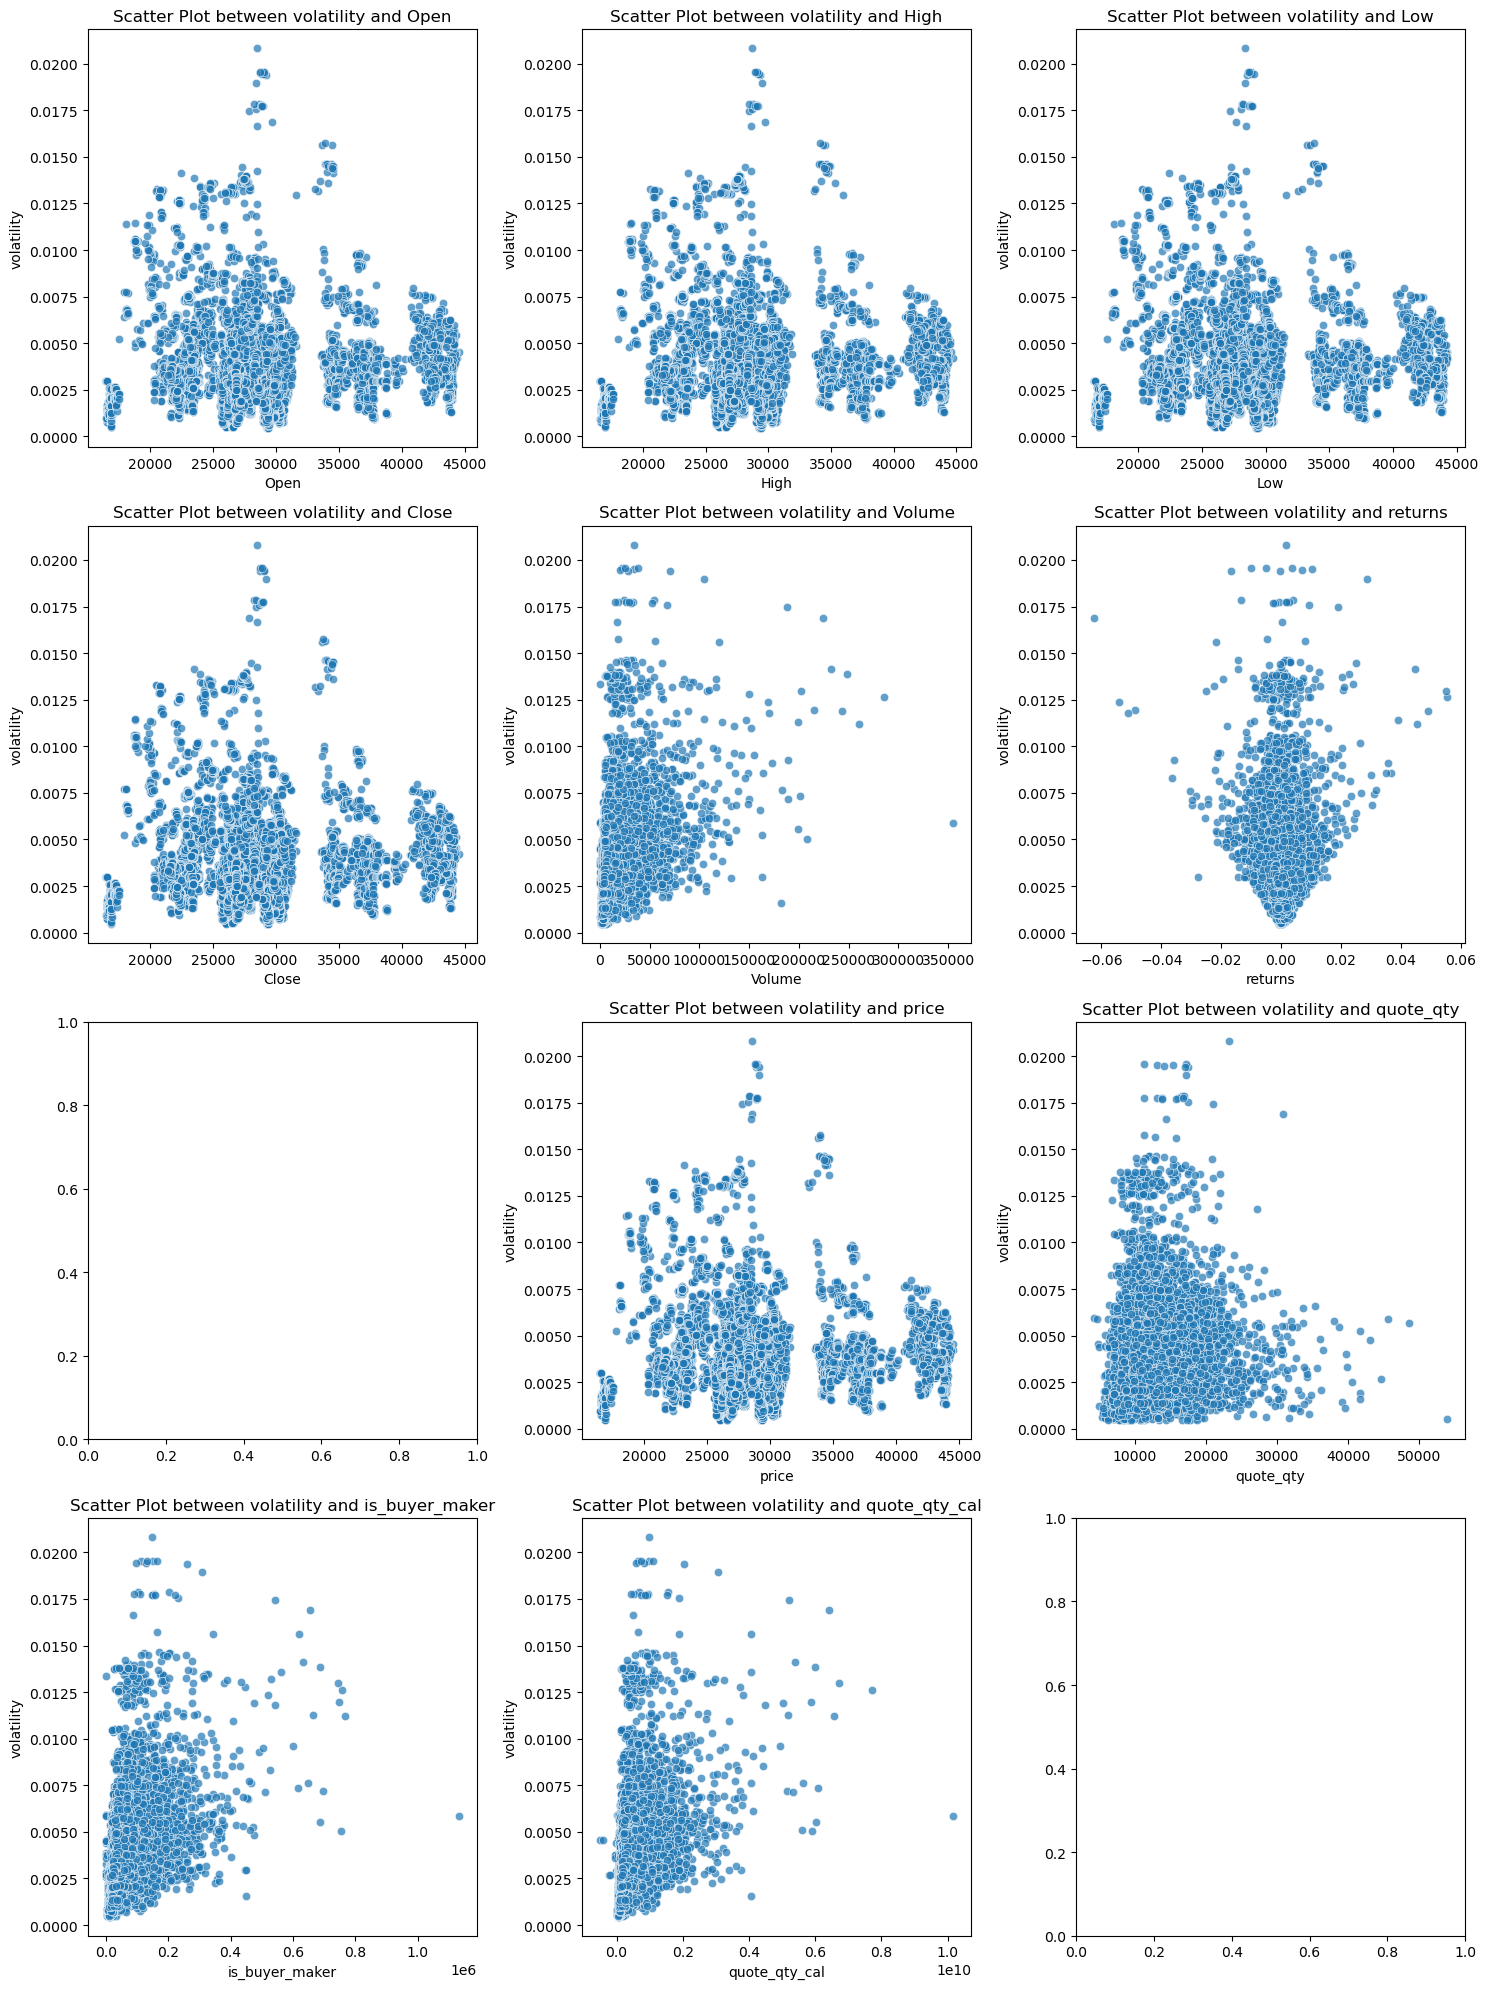

In [65]:
scatter_plot(df, y_col='volatility', title="Scatter Plot")

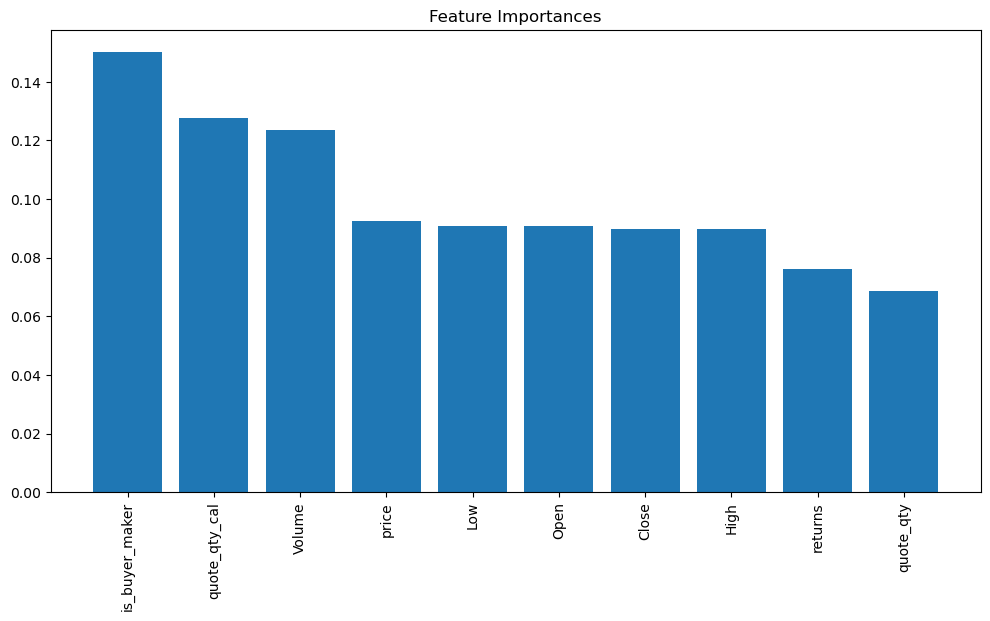

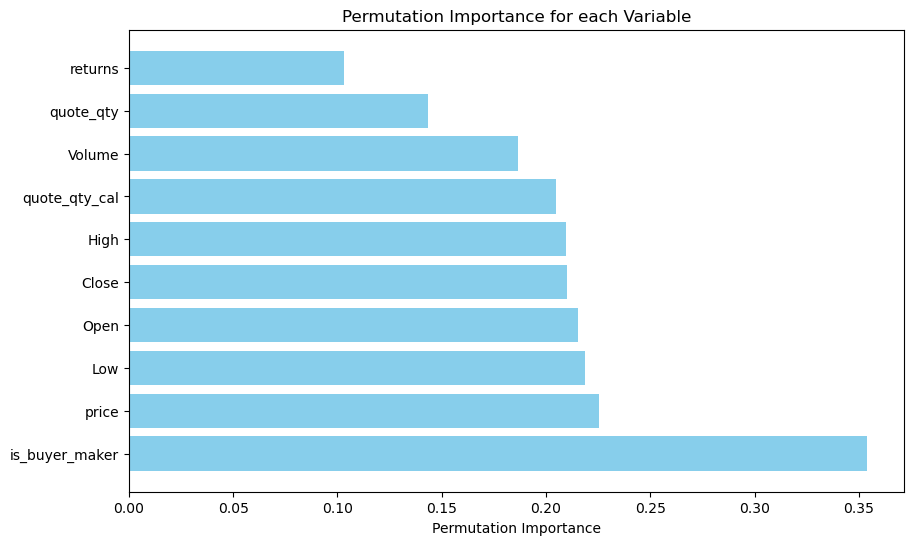

In [67]:
# df 모델링
df_tr, df_te = train_test_split(df, test_size=0.2, random_state=42)
calculate_importance(df_tr, df_te, df_name='df')

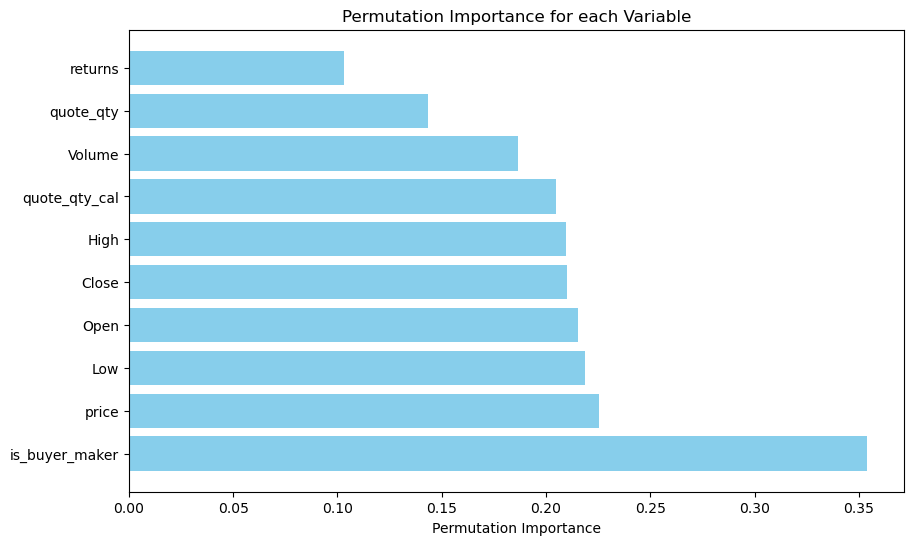

In [68]:
df_tr, df_te = train_test_split(df, test_size=0.2, random_state=42)
FI_PI_HM(df_mm,'df_mm', figsize=(12, 6), threshold=0.2)

## 3. Model Evaluation

## 4. Model Efficiency Optimization

- kfold